# Applied machine learning to estimate material to adsorb CO<sub>2</sub>

**GitHub link:** 

To start this project, I will gather at the beginning all the libraries used to manipulate data and create visualizations.

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_predict  # <---------- change to Stratified K-Fold Cross Validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
#from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV     # <---------- change to Random Search Cross Validation

from scipy.stats.mstats import normaltest
from yellowbrick.classifier import ClassBalance
from imblearn.over_sampling import SMOTE


In [5]:
df = pd.read_excel("CO2_adsorption_v2.xlsx")

## Data understanding

#### Data description:

Data were gathered from an article that compiled hundreds of sources, focusing on three extensively studied materials: carbon-based materials, metal-organic frameworks (MOFs), and polymers (Dziejarski et al., 2023, pp. 3, 20, 36, 41). However, during the previous phase of this project, the need for additional data arose. While I found more records related to carbon-based materials (Yuan et al., 2021, p.11927), there were no comparable findings for the other materials. This lack of comparable findings is consistent with Dziejarski et al. (2023, p.3), which indicates that most of the research is focused on carbon-based materials.

In [9]:
df.head()

,Material_replace,Material,Precursor,Conjugated microporous polymer,Activation agent,Activation temperature_°C,BET surface area_m2/g,Total pore volume_cm3/g,CO2 uptake_mmol/g_25°C,Adsorption pressure_bar,Reference
0,0,Carbon based,Pomegranate peels,NaN,KOH,700.0,585.0,0.28,4.11,1,"(Serafin et al., 2017)"
1,0,Carbon based,Carrot peels,NaN,KOH,700.0,1379.0,0.58,4.18,1,"(Serafin et al., 2017)"
2,0,Carbon based,Fern leaves,NaN,KOH,700.0,1593.0,0.74,4.12,1,"(Serafin et al., 2017)"
3,0,Carbon based,Black locust,NaN,KOH,830.0,2064.0,0.98,3.75,1,"(Zhang et al., 2016)"
4,0,Carbon based,Rice husk char,NaN,KOH,780.0,2965.0,1.14,3.71,1,"(Li et al., 2015a)"


In [10]:
df.shape

(92, 11)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Material_replace                92 non-null     int64  
 1   Material                        92 non-null     object 
 2   Precursor                       73 non-null     object 
 3   Conjugated microporous polymer  19 non-null     object 
 4   Activation agent                50 non-null     object 
 5   Activation temperature_°C       52 non-null     float64
 6   BET surface area_m2/g           88 non-null     float64
 7   Total pore volume_cm3/g         78 non-null     float64
 8   CO2 uptake_mmol/g_25°C          92 non-null     float64
 9   Adsorption pressure_bar         92 non-null     int64  
 10  Reference                       92 non-null     object 
dtypes: float64(4), int64(2), object(5)
memory usage: 8.0+ KB


#### Exploratory Data Analysis (EDA) and Data Cleaning:

For this analysis, I will focus on: 'Material_replace', 'BET surface area_m2/g', 'Total pore volume_cm3/g', and 'CO2 uptake_mmol/g_25°C'. The other features are redundant or specific to a unique material category. For example, 'Material' is the name of the material used in CO<sub>2</sub> adsorption, but it is stored in the feature called 'Material_replace', and the 'Adsorption pressure_bar' that is the same for all materials. The other features are related exclusively to a specific material, such as activated-carbon or polymers.

In [19]:
df1 = df.drop(['Material', 'Precursor', 'Conjugated microporous polymer', 'Activation agent', 'Activation temperature_°C', 'Adsorption pressure_bar', 'Reference'], axis = 1)
df1.head()

,Material_replace,BET surface area_m2/g,Total pore volume_cm3/g,CO2 uptake_mmol/g_25°C
0,0,585.0,0.28,4.11
1,0,1379.0,0.58,4.18
2,0,1593.0,0.74,4.12
3,0,2064.0,0.98,3.75
4,0,2965.0,1.14,3.71


**Renaming columns:**

Before start I will rename the columns to facilated the understanting.

In [22]:
df1.rename(columns=({'Material_replace': 'Material', 'BET surface area_m2/g': 'SA', 'Total pore volume_cm3/g': 'TPV', 'CO2 uptake_mmol/g_25°C': 'CO2_uptake'}), inplace=True)

Now, I will search for missing and null values because they are part of data quality assurance. If the data is inaccurate, it can lead to unreliable analysis, conclusions, and biased results, affecting the model's performance.

After running the function .isnull() again, I can see that I will have to handle missing values from 2 features ('BET surface area_m2/g' and 'Total pore volume_cm3/g').

In [25]:
df1.isnull().sum()

Material       0
SA             4
TPV           14
CO2_uptake     0
dtype: int64

Before addressing the missing values, I will evaluate the descriptive statistics of the data. I will use the '.describe()' function, which generates statistics such as data distribution and variation, crucial for understanding the data's characteristics during the exploratory data analysis (EDA) phase. These insights will also aid in selecting the most appropriate method to handle missing values.

In [28]:
df1.describe()

,Material,SA,TPV,CO2_uptake
count,92.000000,88.000000,78.000000,92.000000
mean,0.641304,1551.824659,0.852388,3.158261
std,0.806315,863.471889,0.510787,1.525911
min,0.000000,240.000000,0.220000,0.580000
25%,0.000000,906.750000,0.512500,1.707500
50%,0.000000,1537.000000,0.745000,3.590000
75%,1.000000,2011.500000,1.014500,4.240000
max,2.000000,5290.000000,2.810000,6.180000


Evaluating the descriptive statistics reveals that the data is skewed, as evidenced by the difference between the mean and median (50%) values. This indicates that the data in these two columns do not follow a normal distribution.

This information is crucial for selecting the appropriate method to impute the missing values, such as mean, median, or interpolation. For instance, I can replace the missing values with the mean when the data follows a normal distribution. However, when the data is skewed, I may opt for the median or interpolation because they are less influenced by extreme values.e.

The function below 'normaltest()' results can prove that these numerical variables ('SA', 'TPV', 'CO2_uptake') do not follow a normal distribution, as the p-values for these variables were extremely low.

In [103]:
result_SA = normaltest(df1['SA'].values)
result_TPV = normaltest(df1['TPV'].values)
result_CO2_uptake = normaltest(df1['CO2_uptake'].values)

print("Normality test results for SA:", result_SA)
print("Normality test results for TPV:", result_TPV)
print("Normality test results for CO2_uptake:", result_CO2_uptake)

Normality test results for SA: NormaltestResult(statistic=28.38145089536004, pvalue=6.871416032607631e-07)
Normality test results for TPV: NormaltestResult(statistic=46.102803474628026, pvalue=9.747728520591592e-11)
Normality test results for CO2_uptake: NormaltestResult(statistic=26.587206936079717, pvalue=1.685238488388121e-06)


Below I will plot the histogram to see the distrubution of 'BET surface area_m2/g', 'Total pore volume_cm3/g', and 'CO2 uptake_mmol/g_25°C'. In these charts we can verify that the distibution do not follow a nomal curve.

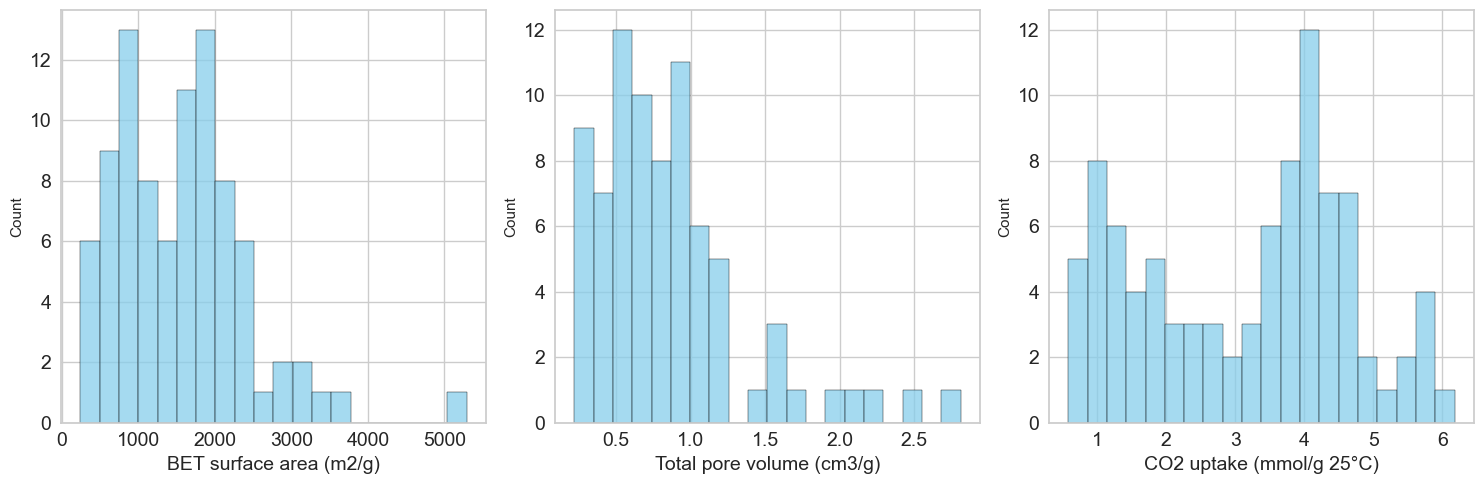

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=df1, x="SA", bins=20, color='skyblue', ax=axs[0])
axs[0].set_xlabel("BET surface area (m2/g)", fontsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)

sns.histplot(data=df1, x="TPV", bins=20, color='skyblue', ax=axs[1])
axs[1].set_xlabel("Total pore volume (cm3/g)", fontsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

sns.histplot(data=df1, x="CO2_uptake", bins=20, color='skyblue', ax=axs[2])
axs[2].set_xlabel("CO2 uptake (mmol/g 25°C)", fontsize=14)
axs[2].tick_params(axis='x', labelsize=14)
axs[2].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

The box plots below indicate the presence of outliers; however, I will only be able to determine if I can remove them by applying the Interquartile Range (IQR) function.

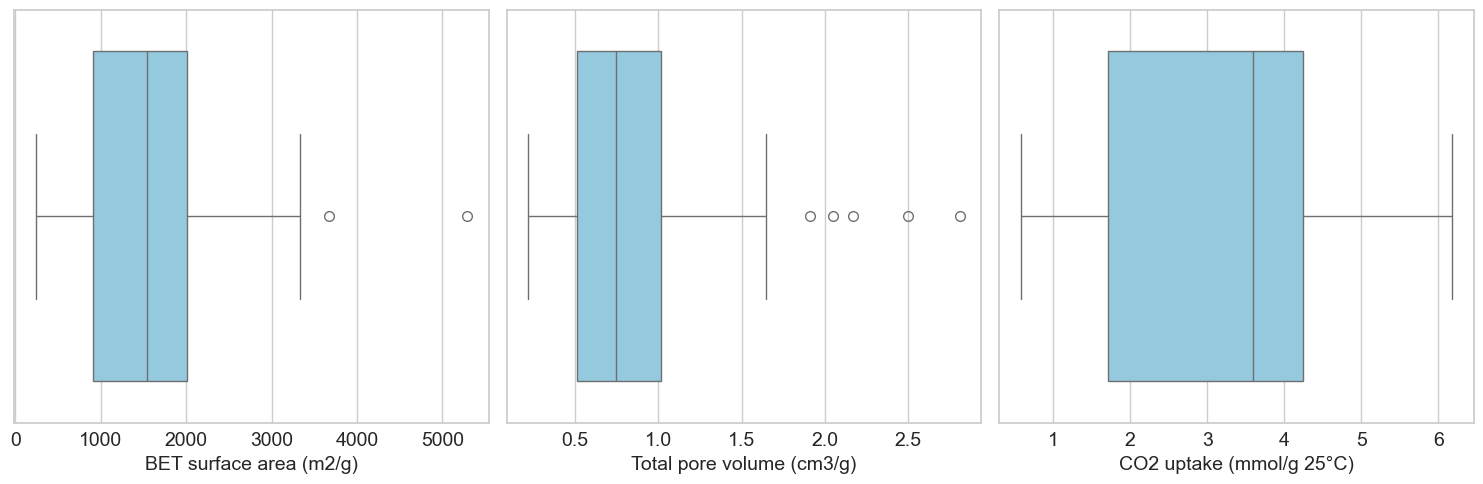

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df1, x="SA", color='skyblue', ax=axs[0])
axs[0].set_xlabel("BET surface area (m2/g)", fontsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)

sns.boxplot(data=df1, x="TPV", color='skyblue', ax=axs[1])
axs[1].set_xlabel("Total pore volume (cm3/g)", fontsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

sns.boxplot(data=df1, x="CO2_uptake", color='skyblue', ax=axs[2])
axs[2].set_xlabel("CO2 uptake (mmol/g 25°C)", fontsize=14)
axs[2].tick_params(axis='x', labelsize=14)
axs[2].tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

I will also check for outliers using the Interquartile Range (IQR) using the function below. Then, if possible I will remove them without losing the data integrity.

In [37]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

In [39]:
df_outliers = df1[~((df1<(Q1-1.5*IQR))|(df1>Q3+1.5*IQR)).any(axis=1)]
df_outliers.shape

(86, 4)

After discovering that 6.5% of the data are outliers, a reasonable amount, I decided not to remove them. Otherwise, I could lose the data integrity, mainly because I have imbalanced classes that may impair the model's performance. 

The histograms confirm that these features are skewed, and the box plot shows the presence of outliers in the features, which was confirmed by the IQR function. Thus, in this case, I will input the missing values with the median because this method is more robust to outliers. Additionally, the interpolation method tends to be suitable when the data changes over time, which is not the case here.

In [43]:
median_col_sa = df1['SA'].median()
median_col_pv = df1['TPV'].median()

In [45]:
df1.fillna({'SA': median_col_sa, 'TPV': median_col_pv}, inplace=True)

In [47]:
df1.isnull().sum()

Material      0
SA            0
TPV           0
CO2_uptake    0
dtype: int64

In [49]:
df1.shape

(92, 4)

Checking for duplicates is essential for maintaining data integrity; otherwise, it can lead to inaccurate results. Thus, I used the '.duplicated()' function to identify duplicates and the '.sum()' function to aggregate duplicated values, resulting in zero duplicates.

In [52]:
df1.duplicated().sum()

0

#### Descriptive Statistic

Descriptive statistics simply summarize and describe the main features, helping us understand the basic characteristics of the dataset. They summarize measures of central tendency such as the mean, median, and mode, as well as measures of dispersion such as standard deviation, variance, percentiles, and correlation coefficients (Nicholas, 1999, p.1,5; Devore, 2012, p.4).

In [56]:
df1.describe()

,Material,SA,TPV,CO2_uptake
count,92.000000,92.000000,92.000000,92.000000
mean,0.641304,1551.180109,0.836047,3.158261
std,0.806315,844.286701,0.471454,1.525911
min,0.000000,240.000000,0.220000,0.580000
25%,0.000000,948.000000,0.550000,1.707500
50%,0.000000,1537.000000,0.745000,3.590000
75%,1.000000,1986.500000,0.980000,4.240000
max,2.000000,5290.000000,2.810000,6.180000


##### Sparsity of the data
Sparse datasets are characterized by most features having 0 most of the time (Müller and Guido, 2017 p.44) and the sparsity is a measurement of how sparse or dense a dataset is. It can be represented as the ratio of the number of zero or missing values to the total number of data points or entries in the dataset. 

In [59]:
missing_values = df1.isnull().sum().sum()
zero_values = (df1 == 0).sum().sum()

total_data_points = df1.size

sparsity = (missing_values + zero_values) / total_data_points

print(f"Sparsity of the dataset: {sparsity:.3f}")

Sparsity of the dataset: 0.141


In [61]:
print("Missing values: ", missing_values)
print("zero_values: ", zero_values)

Missing values:  0
zero_values:  52


The sparsity values must be between 0 and 1, where 0 indicates no sparsity and 1 indicates complete sparsity. The result for this dataset was found to be 0.141, meaning that 14.1% of the values in the dataset are zero, as the missing values were handled. Thus, this data has a reasonable portion of zero values.

These zero values likely originated from the 'Material' feature used to encode the material classes. I will employ the one-hot encoding method during the preprocessing phase to ensure equal weight for each material class. However, the dataset may still remain sparse due to the one-hot encoding process, which automatically generates many zeros.

##### Data correlations

The charts below (pair plot and heatmap) show the relation between features and their strength and direction of the relationship. I dropped the 'Material' feature because it does not provide essential information since it is a representation of a categorical feature.

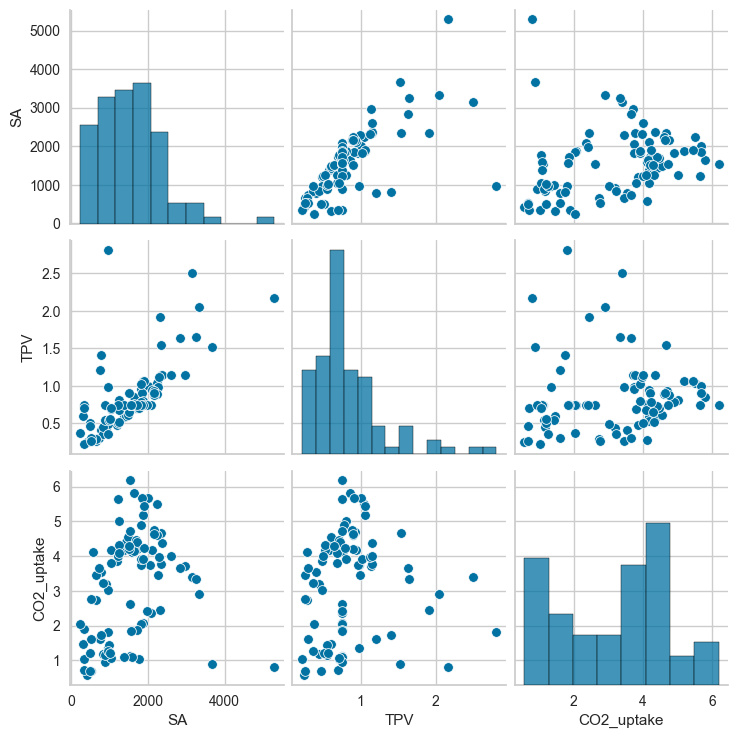

In [65]:
df1_plot = df1.drop(['Material'], axis=1)
sns.pairplot(df1_plot)

,SA,TPV,CO2_uptake
SA,1.000000,0.696039,0.271667
TPV,0.696039,1.000000,0.071037
CO2_uptake,0.271667,0.071037,1.000000


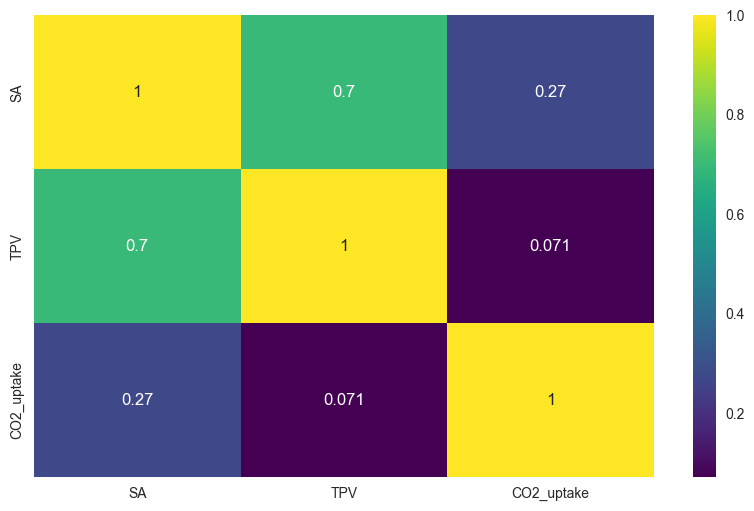

In [66]:
plt.figure(figsize=(10,6)) 
c= df1_plot.corr() 
sns.heatmap(c,cmap="viridis",annot=True) 
c

The pair plot and heatmap char showed a moderately strong positive correlation between SA and TPV (0.70); thus, there was a tendency to increase area at the same time as increasing volume and vice versa. However, when comparing CO2_uptake with SA (0.23), the correlation was weak if compared with Area and Volume. In addition, practically, there was no correlation between CO2_uptake and TPV (0.085), meaning little or no linear correlation that can be negligible.

#### Inferential Statistics

##### Hypothesis test

Considering that the data are not normally distributed, I used a non-parametric test because it generates more reliable results in this case than a parametric test. I applied the Kruskal-Wallis test because it is appropriate for handling a non-normal distribution (Devore, 2012, p.645).

I utilized the Scipy library, employing the 'kruskal()' function for conducting this statistical test and calculating the p-value (docs.scipy.org, n.d.).  

*Hypothesis:*
    
$H_0$: There is no significant difference in the CO<sub>2</sub> adsorption capacity among the materials tested.

$H_1$: There is a significant difference in the CO<sub>2</sub> adsorption capacity among the materials tested.
  
Considering 95% of confidence level and 𝛼 = 0.05 I will calculate the p-value to know if there is a significant difference between the CO<sub>2</sub> adsorption for each material. 

In [71]:
df1.head()

,Material,SA,TPV,CO2_uptake
0,0,585.0,0.28,4.11
1,0,1379.0,0.58,4.18
2,0,1593.0,0.74,4.12
3,0,2064.0,0.98,3.75
4,0,2965.0,1.14,3.71


In [73]:
material_0 = df1[df1['Material'] == 0]['CO2_uptake']
material_1 = df1[df1['Material'] == 1]['CO2_uptake']
material_2 = df1[df1['Material'] == 2]['CO2_uptake']

h_statistic, p_value = kruskal(material_0, material_1, material_2)

print("H-Statistic:", h_statistic)
print("P-Value:", p_value)

H-Statistic: 43.178459017457286
P-Value: 4.2064599257196557e-10


As we can see above, the p-value is less than 𝛼, thus I can reject the null hypothesis, suggesting a significant difference among at least one pair of materials regarding CO<sub>2</sub> adsorption.

After performing the Dunn test to identify which specific pairs of materials are different, I found that all of them are significantly different, considering the p-values less than 𝛼 = 0.05. The result is illustrated below in a chart.

In [76]:
# Combine data into a list of lists
all_data = [material_0, material_1, material_2]

# Perform Kruskal-Wallis test
h_statistic, p_value = kruskal(*all_data)

# Check if the overall Kruskal-Wallis test is significant
if p_value < 0.05:
    # Perform Dunn post-hoc test for pairwise comparisons
    results = sp.posthoc_dunn(all_data, p_adjust='bonferroni')
    print("Dunn Test Results:")
    print(results)
else:
    print("No significant difference in the Kruskal-Wallis test.")


Dunn Test Results:
              1         2             3
1  1.000000e+00  0.002344  6.142024e-10
2  2.343527e-03  1.000000  2.490303e-02
3  6.142024e-10  0.024903  1.000000e+00


In [78]:
# Material 0:
mean_material_0 = np.mean(material_0)
std_dev_material_0 = np.std(material_0, ddof=1)

# Material 1:
mean_material_1 = np.mean(material_1)
std_dev_material_1 = np.std(material_1, ddof=1)

# Material 2:
mean_material_2 = np.mean(material_2)
std_dev_material_2 = np.std(material_2, ddof=1)

print(mean_material_0, std_dev_material_0)
print(mean_material_1, std_dev_material_1)
print(mean_material_2, std_dev_material_2)

4.077115384615384 0.7658606245455246
2.588571428571429 1.7475276413101044
1.273157894736842 0.384188215325928


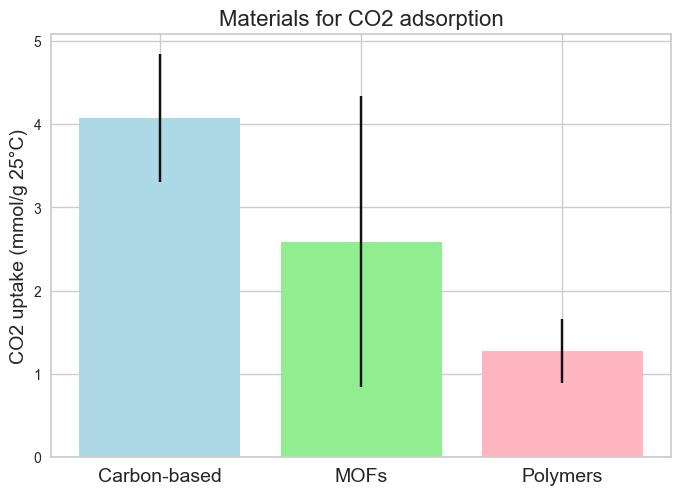

In [80]:
materials = ['Carbon-based', 'MOFs', 'Polymers']
means = [mean_material_0, mean_material_1, mean_material_2]
std_devs = [std_dev_material_0, std_dev_material_1, std_dev_material_2]

fig, ax = plt.subplots()
ax.bar(materials, means, yerr=std_devs, capsize=5, color=['lightblue', 'lightgreen', 'lightpink'])
ax.set_ylabel('CO2 uptake (mmol/g 25°C)', fontsize=14)
ax.set_title('Materials for CO2 adsorption', fontsize=16)
plt.xticks(fontsize=14)
plt.show()

# Data Preparation

### Data preprocessing:

In this phase, I will preprocess the data, making them suitable for the ML model, like standardizing all features to be on the same scale to reduce memory and time consumption and avoid missed calculations. I will also use one-hot encoding to avoid attributing weight to the categories, avoiding the situation where one material has more advantages over another.

**One-hot encoding**

I will use the pd.get_dummies function from the panda's library to perform the one-hot encoding. 

In [86]:
df_encod = pd.get_dummies(df1, columns=['Material'], dtype=int)
df_encod.head()

,SA,TPV,CO2_uptake,Material_0,Material_1,Material_2
0,585.0,0.28,4.11,1,0,0
1,1379.0,0.58,4.18,1,0,0
2,1593.0,0.74,4.12,1,0,0
3,2064.0,0.98,3.75,1,0,0
4,2965.0,1.14,3.71,1,0,0


In [88]:
df_encod.shape

(92, 6)

In [90]:
missing_values = df_encod.isnull().sum().sum()
zero_values = (df_encod == 0).sum().sum()

total_data_points = df_encod.size

sparsity = (missing_values + zero_values) / total_data_points

print(f"Sparsity of the dataset: {sparsity:.3f}")

Sparsity of the dataset: 0.333


In [92]:
print("Missing values: ", missing_values)
print("zero_values: ", zero_values)

Missing values:  0
zero_values:  184


As we can see in the results above, the sparsity increased by 2.4 times after the one-hot encoding; however, it's necessary not to assign weight to categories in the material features.

**Data scaling**

Data scaling is a common preprocessing for many ML models because there is a considerable variation between features that can contribute to inaccurate predictions since features with larger scales may dominate the calculations (Müller and Guido, 2017, p.138). However, in the presence of outliers, is generally necessary robust methods to handle it, such as the RobustScaler function that considers the median and the interquartile range (sci-kit-learn, n.d.). As I identified that this dataset contains 6.5% outliers, I will use the RobustScaler to deal with these outliers.

Before beginning standardization, I will drop the material columns since they are the result of one-hot encoding and already have values between zero and one, making them ready for standardization alongside the numerical columns ('SA', 'TPV', and 'CO2_uptake').  

In [97]:
df_norm = df_encod.drop(columns=["Material_0", "Material_1", "Material_2"])
df_norm.head()

,SA,TPV,CO2_uptake
0,585.0,0.28,4.11
1,1379.0,0.58,4.18
2,1593.0,0.74,4.12
3,2064.0,0.98,3.75
4,2965.0,1.14,3.71


I will use the function RobustScaler from the SKlearn library to standardize the data.

In [100]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_norm)

**Imbalanced classes**

According to the function '.value_counts()' below, the data have significantly imbalanced classes. This observation is consistent with the research of Dziejarski et al. (2023, p.3), which highlights the predominant focus on carbon-based materials in existing literature. Furthermore, I encountered challenges in sourcing additional data for materials such as MOFs and polymers.

In [103]:
df1["Material"].value_counts()

Material
0    52
1    21
2    19
Name: count, dtype: int64

Below, I am using the Yellowbrick library to visualize the imbalanced classes. As we can see, MOFs and polymers materials are undersampled compared to carbon-based material.

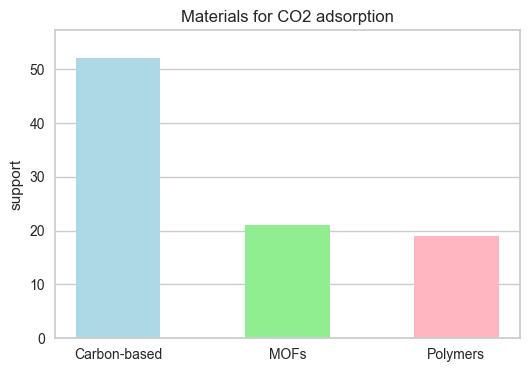

In [106]:
X1 = df1.drop(columns=["Material"])
y1 = df1["Material"]
custom_colors = ['lightblue', 'lightgreen', 'lightpink']
fig, ax = plt.subplots(figsize=(6, 4))
cb_viz = ClassBalance(labels=['Carbon-based', 'MOFs', 'Polymers'], colors=custom_colors, title="Materials for CO2 adsorption")
cb_viz.fit(y1)
cb_viz.poof();

Handling imbalance can be challenging; undersampling may potentially remove important records, while oversampling can lead to overfitting (Chawla, 2010, p.879). Despite that, I believe that I can overcome this challenge using the Synthetic Minority Over-sampling Technique (SMOTE) to address this problem. This technique was demonstrated by Chawla (2002) and is applied in the '.SMOTE()' function (imbalanced-learn.org, n.d.) used in this project, with potentially better generalization compared to traditional methods.

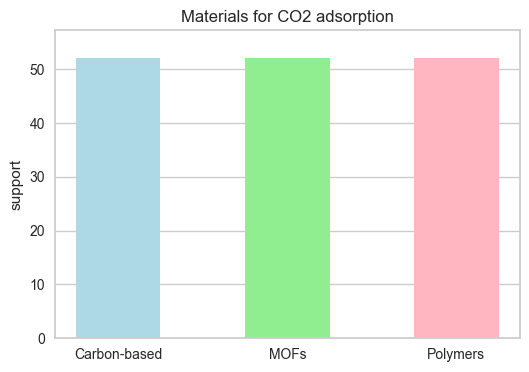

In [109]:
X1 = df1.drop(columns=["Material"])
y1 = df1["Material"]

smote = SMOTE(random_state=11)  
X_resampled, y_resampled = smote.fit_resample(X1, y1)
custom_colors = ['lightblue', 'lightgreen', 'lightpink']
fig, ax = plt.subplots(figsize=(6, 4))
cb_viz = ClassBalance(labels=['Carbon-based', 'MOFs', 'Polymers'], colors=custom_colors, title="Materials for CO2 adsorption")
cb_viz.fit(y_resampled)
cb_viz.poof();

# Machine Learning Models

## Models Screening

In this section, I will apply seven ML models to identify the three that resulted in good performance. I will experiment with the use or non-use of SMOTE. In this screening, the chosen metric is F-score when the data is imbalanced and Accuracy when the data is balanced. Since accuracy might not be appropriate when the data is imbalanced, the F-score metric tends to be more reliable in this case as it is a trade-off between precision and recall in the rare class (Chawla, 2010, p. 876-878). This differentiation is essential to reduce bias when giving more weight to one class over the other.    

Below, I will convert the array of the data scaled into a dataframe to posteriorly merge the columns dropped earlier ("Material_0", "Material_1", "Material_2"). The new dataset will named 'df_ml'. 

In [114]:
array_data = np.array(data_scaled)
column_labels = ['SA', 'TPV', 'CO2_uptake']
df_ar = pd.DataFrame(array_data, columns=column_labels)
df_ar.head()

,SA,TPV,CO2_uptake
0,-0.916707,-1.081395,0.205331
1,-0.152143,-0.383721,0.232971
2,0.053924,-0.011628,0.209279
3,0.507463,0.546512,0.063179
4,1.375060,0.918605,0.047384


In [116]:
df_ml = pd.merge(df_ar, df_encod[["Material_0", "Material_1", "Material_2"]], left_index=True, right_index=True, how='left')
df_ml.head()

,SA,TPV,CO2_uptake,Material_0,Material_1,Material_2
0,-0.916707,-1.081395,0.205331,1,0,0
1,-0.152143,-0.383721,0.232971,1,0,0
2,0.053924,-0.011628,0.209279,1,0,0
3,0.507463,0.546512,0.063179,1,0,0
4,1.375060,0.918605,0.047384,1,0,0


##### Train-test split

Now, I will prepare the data to split for screening.

The target variable will be the 'Materice' because I want to identify which material can be suitable given a certain amount of CO2 uptake desired by the industry.s will define the X and y variables. Then, I will use 'idxmax' to flatten the target variable without introducing different weights to the classes. This is necessary to ensure that the target variable is in a format suitable for training the model (class indices format)sses.

In [119]:
X = df_ml.drop(["Material_0", "Material_1", "Material_2"], axis=1)
y = df_ml[["Material_0", "Material_1", "Material_2"]]
y = y.idxmax(axis=1)

In [121]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=26)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [123]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62, 3), (30, 3), (62,), (30,))

#### ML screening without SMOTE

In [126]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [128]:
models = []
models.append(('GBM', GradientBoostingClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('AB', AdaBoostClassifier(algorithm='SAMME', random_state=12)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

I will use the F1_weighted metric because it is useful when dealing with multiclass classification and class imbalance, which is the situation in this project (scikit-learn, 2019).

In [131]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.model_selection import train_test_split, KFold, cross_val_score

scoring = 'f1_weighted'
n_splits = 3
results = []
names = []
for name, model in models:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=16)
    cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.nanmean(cv_results), np.nanstd(cv_results))
    print(msg)

GBM: 0.911605 (0.065790)
CART: 0.882057 (0.014220)
AB: 0.862838 (0.023969)
RF: 0.862838 (0.023969)
KNN: 0.826064 (0.029113)
NB: 0.868850 (0.058420)
SVM: 0.857742 (0.051400)


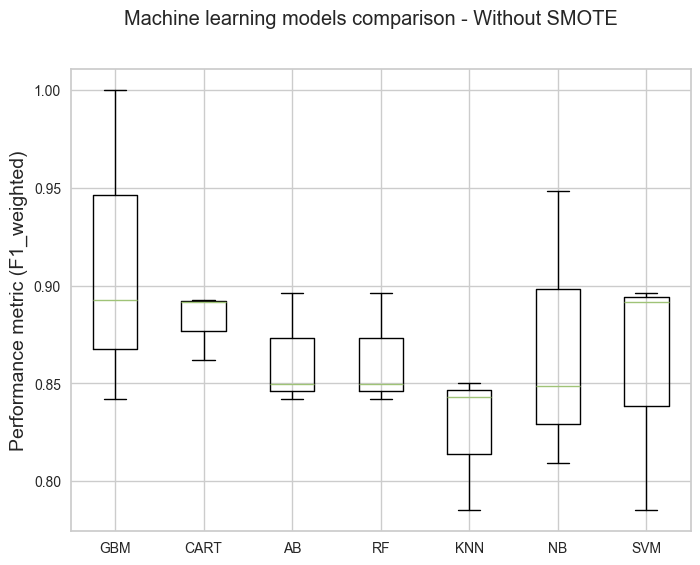

In [133]:
from matplotlib import pyplot

fig = pyplot.figure()   
fig.suptitle('Machine learning models comparison - Without SMOTE')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Performance metric (F1_weighted)', fontsize=14)
fig.set_size_inches(8,6)
pyplot.show()

In [135]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [137]:
from sklearn.metrics import classification_report

predictions = model.predict(X_test)
print(f1_score(y_test, predictions, average='weighted'))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8432005060088552
[[14  3  0]
 [ 0  6  1]
 [ 0  1  5]]
              precision    recall  f1-score   support

  Material_0       1.00      0.82      0.90        17
  Material_1       0.60      0.86      0.71         7
  Material_2       0.83      0.83      0.83         6

    accuracy                           0.83        30
   macro avg       0.81      0.84      0.81        30
weighted avg       0.87      0.83      0.84        30



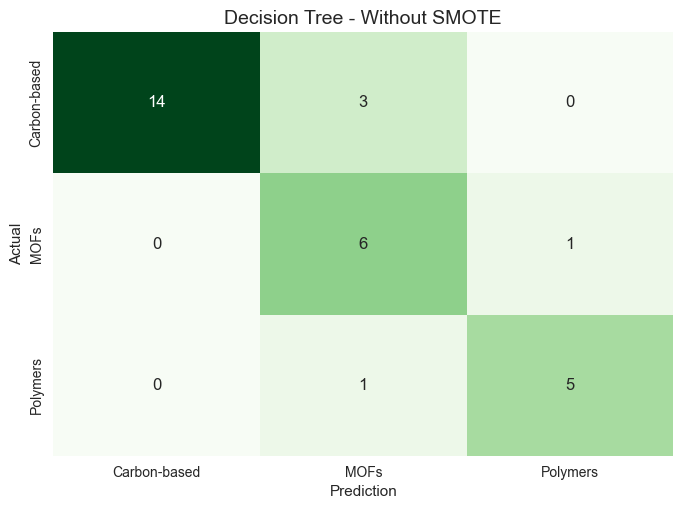

In [139]:
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cm, annot=True, cmap='Greens',
                 xticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                 yticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                 cbar=False)
ax.set_title("Decision Tree - Without SMOTE", fontsize=14)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()

#### ML screening with SMOTE

I will use the oversampling technique (SMOTE) only in the training set to prevent leakage and biased information from the test set. Since the classes are balanced in this case with the SMOTE, I will be able to use accuracy as a metric to evaluate the model's performance.

In [144]:
smote = SMOTE(random_state=11)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [146]:
X_train_resampled.shape, y_train_resampled.shape

((105, 3), (105,))

In [148]:
models = []
models.append(('GBM', GradientBoostingClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('AB', AdaBoostClassifier(algorithm='SAMME', random_state=12)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [150]:
scoring = 'accuracy'
n_splits = 3
results = []
names = []
for name, model in models:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=16)
    cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.nanmean(cv_results), np.nanstd(cv_results))
    print(msg)

GBM: 0.952381 (0.026937)
CART: 0.961905 (0.035635)
AB: 0.904762 (0.026937)
RF: 0.933333 (0.026937)
KNN: 0.876190 (0.048562)
NB: 0.885714 (0.061721)
SVM: 0.885714 (0.023328)


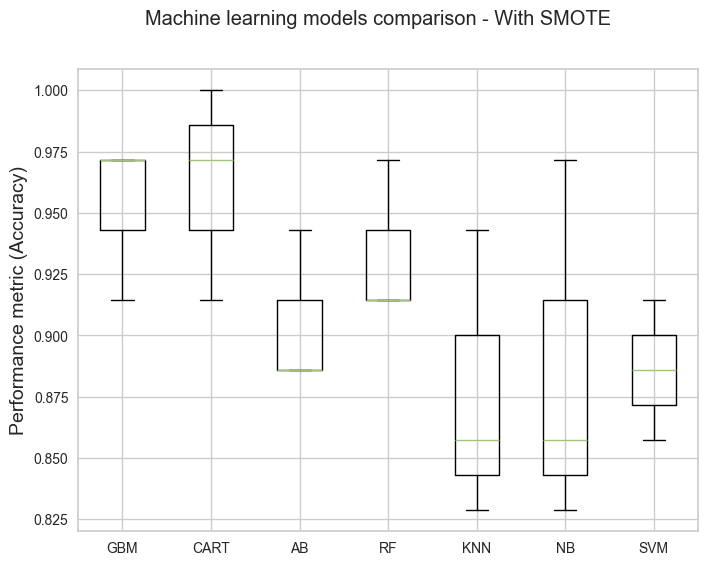

In [151]:
fig = pyplot.figure()
fig.suptitle('Machine learning models comparison - With SMOTE')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Performance metric (Accuracy)', fontsize=14)
fig.set_size_inches(8,6)
pyplot.show()

In [154]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [156]:
predictions_smote = model.predict(X_test)
print(accuracy_score(y_test, predictions_smote))
print(confusion_matrix(y_test, predictions_smote))
print(classification_report(y_test, predictions_smote))

0.8333333333333334
[[14  3  0]
 [ 0  6  1]
 [ 0  1  5]]
              precision    recall  f1-score   support

  Material_0       1.00      0.82      0.90        17
  Material_1       0.60      0.86      0.71         7
  Material_2       0.83      0.83      0.83         6

    accuracy                           0.83        30
   macro avg       0.81      0.84      0.81        30
weighted avg       0.87      0.83      0.84        30



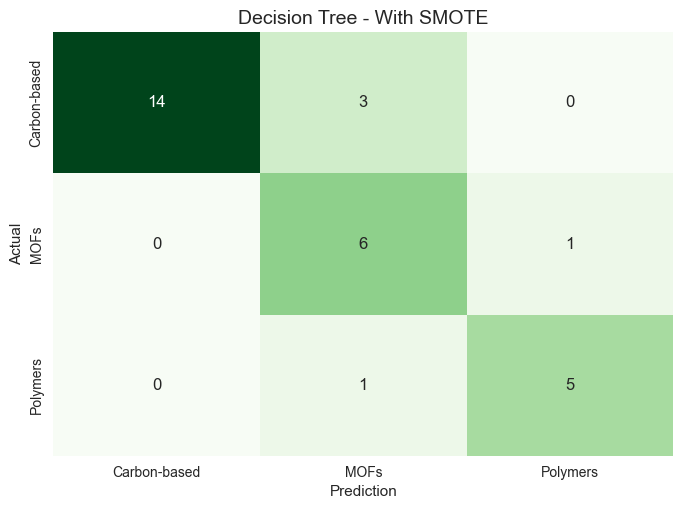

In [158]:
cm = confusion_matrix(y_test, predictions_smote)
ax = sns.heatmap(cm, annot=True, cmap='Greens',
                 xticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                 yticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                 cbar=False)
ax.set_title("Decision Tree - With SMOTE", fontsize=14)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()

##### ML screening Evaluation

Considering that in this project I am interested in prioritizing true positive results, I will focus on identify models that correctly identify positive instances, because of this I will evaluate metrics such as recall, precision, and f1_score.

In the confusion matrix with SMOTE and without SMOTE using n_splits = 3, the classification error for the minority classes (MOFs and Polymers) was only one instance for each, a promising result.

Looking at the charts below with the summary of the performance of a variety of conditions tested, like with SMOTE, without SMOTE, with n_splits = 3, and n_splits = 5; we can see that all tested conditions performed well, with scores above 0.86. Also, the top models performed similarly across these conditions (Decision Tree Classifier (CART), Gradient Boosting Classifier (GBM), Random Forest Classifier (RF), and Ada Boost Classifier (AB).

However, the condition without SMOTE and n_splits equal to 3 notably improved the precision, recall, and F1-score in the two minority material classes, MOFS (class 1) and Polymers (class 2). Given the significance of accurate classification for these minority classes in comparison to the majority class, Carbon-based (class 0), I will opt for these conditions to implement the three best-performing models, namely: Decision Tree Classifier (CART), Gradient Boosting Classifier (GBM), and Random Forest Classifier (RF).

+-----------+-----------------------+-------------------------+
| Metrics   |   No SMOTE (F1_score) |   With SMOTE (Accuracy) |
+===========+=======================+=========================+
| AB        |                 0.863 |                   0     |
+-----------+-----------------------+-------------------------+
| RF        |                 0.863 |                   0.904 |
+-----------+-----------------------+-------------------------+
| GBM       |                 0.853 |                   0.936 |
+-----------+-----------------------+-------------------------+
| CART      |                 0     |                   0.912 |
+-----------+-----------------------+-------------------------+


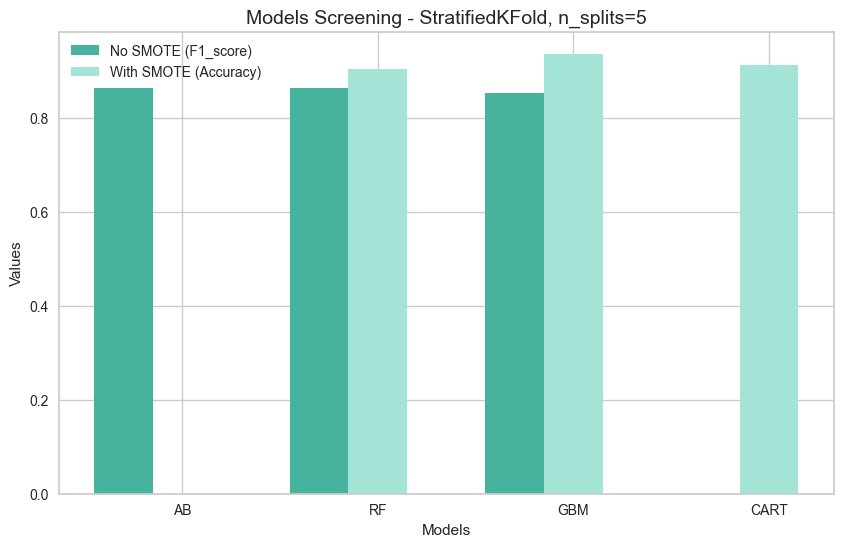

In [161]:
data = [
    ["AB", 0.863, 0],
    ["RF", 0.863, 0.904],
    ["GBM", 0.853, 0.936],
    ["CART", 0, 0.912]
]
headers = ["Metrics", "No SMOTE (F1_score)", "With SMOTE (Accuracy)"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_ns = [row[1] for row in data]
values_ws = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_ns, width=bar_width, label=headers[1], color='#45B39D')
plt.bar(index + bar_width, values_ws, width=bar_width, label=headers[2], color='#A3E4D7')

plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Models Screening - StratifiedKFold, n_splits=5', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend()
plt.show()

+-----------+-----------------------+-------------------------+
| Metrics   |   No SMOTE (F1_score) |   With SMOTE (Accuracy) |
+===========+=======================+=========================+
| AB        |                 0.862 |                   0     |
+-----------+-----------------------+-------------------------+
| RF        |                 0.862 |                   0.942 |
+-----------+-----------------------+-------------------------+
| GBM       |                 0.891 |                   0.952 |
+-----------+-----------------------+-------------------------+
| CART      |                 0.912 |                   0.961 |
+-----------+-----------------------+-------------------------+


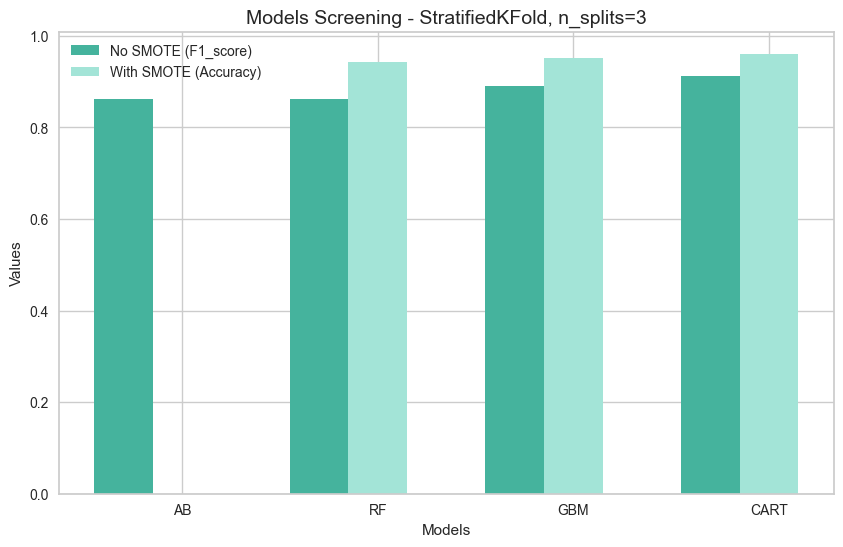

In [163]:
data = [
    ["AB", 0.862, 0],
    ["RF", 0.862, 0.942],
    ["GBM", 0.891, 0.952],
    ["CART", 0.912, 0.961]
]
headers = ["Metrics", "No SMOTE (F1_score)", "With SMOTE (Accuracy)"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_ns = [row[1] for row in data]
values_ws = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_ns, width=bar_width, label=headers[1], color='#45B39D')
plt.bar(index + bar_width, values_ws, width=bar_width, label=headers[2], color='#A3E4D7')

plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Models Screening - StratifiedKFold, n_splits=3', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend()
plt.show()

## Implementation

#### Without SMOTE

In [178]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [180]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
}

In [182]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=26)

In [184]:
param_distributions = {
    'Decision Tree': {'decisiontreeclassifier__max_depth': [1, 2, 3, 5, 7, 10, 20, 25, 30],
                      'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                      'decisiontreeclassifier__random_state': [87]
                     },
    'Gradient Boosting': {'gradientboostingclassifier__n_estimators': [50, 100, 150, 200, 1000],
                          'gradientboostingclassifier__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
                          'gradientboostingclassifier__max_depth': [1, 2, 3, 5, 7, 10, 20, 25, 30],
                          'gradientboostingclassifier__min_samples_leaf': [1, 2, 3, 4], 
                          'gradientboostingclassifier__min_samples_split': [2, 3],
                          'gradientboostingclassifier__subsample': [0.1, 0.3, 0.5, 0.8],
                          'gradientboostingclassifier__random_state': [87]
                         },
    'Random Forest': {'randomforestclassifier__n_estimators':[100,150,200],
                      'randomforestclassifier__max_depth':[2,5,10],
                      'randomforestclassifier__max_features': ['sqrt', 'log2'],
                      'randomforestclassifier__criterion': ['gini','entropy'],
                      'randomforestclassifier__random_state': [87]
                     }
}

We can get accuracy of 0.8880952380952382 on the Train set using {'decisiontreeclassifier__random_state': 87, 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__criterion': 'gini'}
Classifier: Decision Tree
Metrics for Train Set:
Accuracy: 0.94
Precision:" 0.94
Recall:" 0.94
F1 Score:" 0.93
Metrics for Test Set:
Accuracy:" 0.83
Precision:" 0.82
Recall:" 0.83
F1 Score:" 0.82


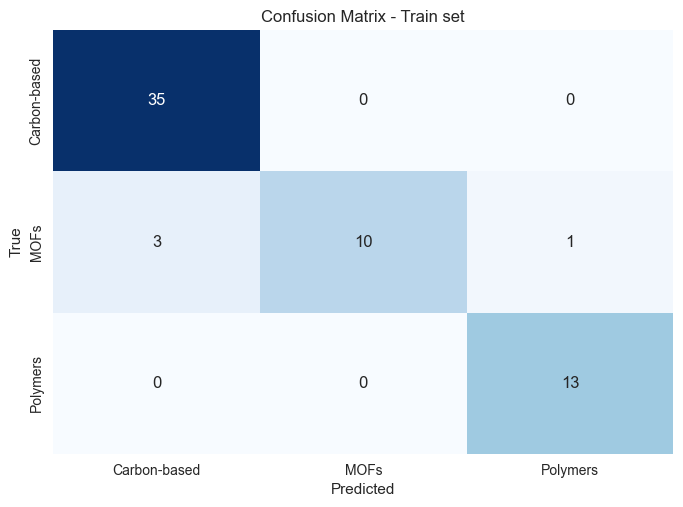

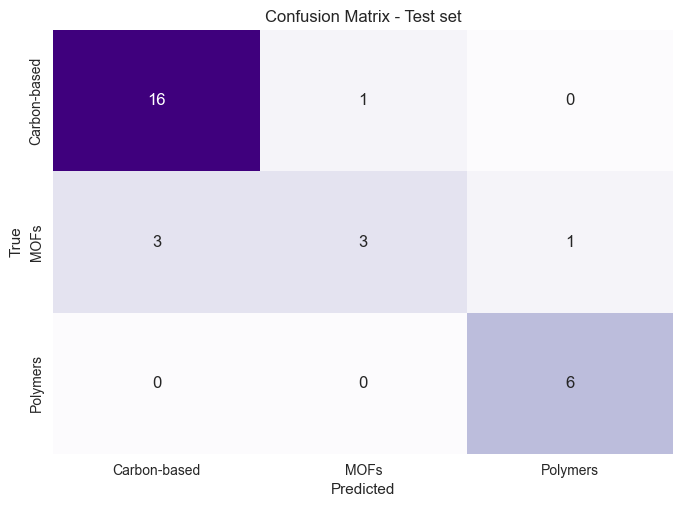

We can get accuracy of 0.9031746031746032 on the Train set using {'gradientboostingclassifier__subsample': 0.3, 'gradientboostingclassifier__random_state': 87, 'gradientboostingclassifier__n_estimators': 150, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__min_samples_leaf': 4, 'gradientboostingclassifier__max_depth': 30, 'gradientboostingclassifier__learning_rate': 0.03}
Classifier: Gradient Boosting
Metrics for Train Set:
Accuracy: 0.97
Precision:" 0.97
Recall:" 0.97
F1 Score:" 0.97
Metrics for Test Set:
Accuracy:" 0.83
Precision:" 0.82
Recall:" 0.83
F1 Score:" 0.82


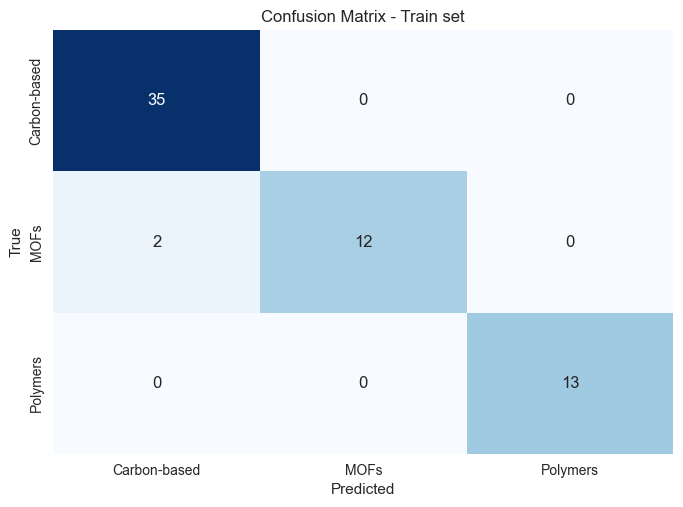

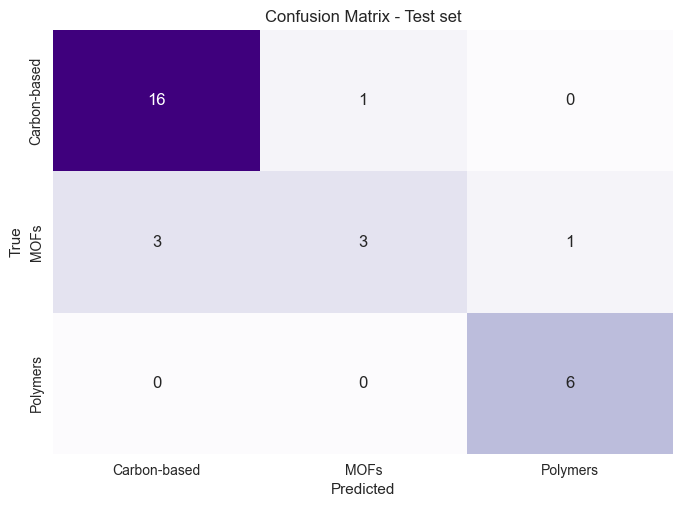

We can get accuracy of 0.8714285714285714 on the Train set using {'randomforestclassifier__random_state': 87, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__criterion': 'gini'}
Classifier: Random Forest
Metrics for Train Set:
Accuracy: 0.98
Precision:" 0.98
Recall:" 0.98
F1 Score:" 0.98
Metrics for Test Set:
Accuracy:" 0.83
Precision:" 0.82
Recall:" 0.83
F1 Score:" 0.82


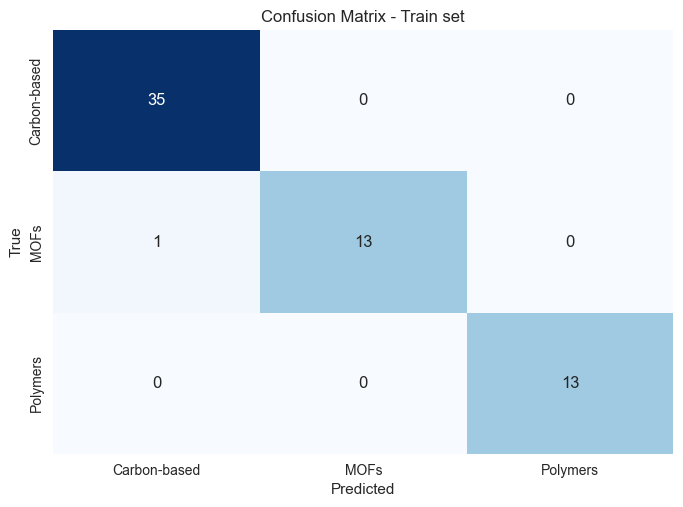

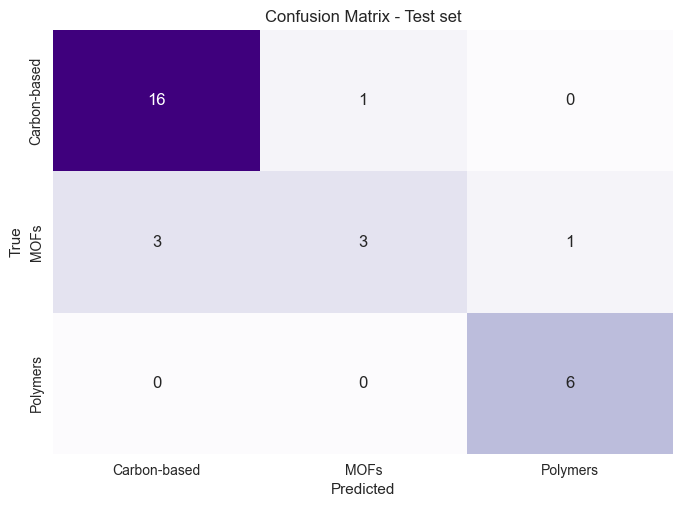

In [186]:
# Perform RandomizedSearchCV for each classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, clf in classifiers.items():
    pipe = make_pipeline(clf)
    random_search = RandomizedSearchCV(pipe, param_distributions=param_distributions[name], cv=skf, scoring='accuracy')
    random_search.fit(X_train, y_train)
    print('We can get accuracy of',random_search.best_score_,'on the Train set using',random_search.best_params_)
    
    # Train set metrics
    train_predictions = random_search.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions, average='weighted')
    train_recall = recall_score(y_train, train_predictions, average='weighted')
    train_f1_score = f1_score(y_train, train_predictions, average='weighted')
    
    # Test set metrics
    test_predictions = random_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions, average='weighted')
    test_recall = recall_score(y_test, test_predictions, average='weighted')
    test_f1_score = f1_score(y_test, test_predictions, average='weighted')

    print("Classifier:", name)
    print('Metrics for Train Set:')
    print(f'Accuracy: {train_accuracy:.2f}')
    print(f'Precision:" {train_precision:.2f}')
    print(f'Recall:" {train_recall:.2f}')
    print(f'F1 Score:" {train_f1_score:.2f}')
    
    print('Metrics for Test Set:')
    print(f'Accuracy:" {test_accuracy:.2f}')
    print(f'Precision:" {test_precision:.2f}')
    print(f'Recall:" {test_recall:.2f}')
    print(f'F1 Score:" {test_f1_score:.2f}')

    # Confusion Matrix for train set
    cm_test = confusion_matrix(y_train, train_predictions)
    sns.heatmap(cm_test, annot=True, cmap='Blues',
                xticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                yticklabels=['Carbon-based', 'MOFs', 'Polymers'], cbar=False)
    plt.title('Confusion Matrix - Train set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Confusion Matrix for test set
    cm_test = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm_test, annot=True, cmap='Purples',
                xticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                yticklabels=['Carbon-based', 'MOFs', 'Polymers'], cbar=False)
    plt.title('Confusion Matrix - Test set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

+-----------+-------------+------------+
| Metrics   |   Train set |   Test set |
+===========+=============+============+
| Acurracy  |        0.92 |       0.83 |
+-----------+-------------+------------+
| Precision |        0.93 |       0.82 |
+-----------+-------------+------------+
| Recall    |        0.92 |       0.83 |
+-----------+-------------+------------+
| F1 Score  |        0.91 |       0.82 |
+-----------+-------------+------------+


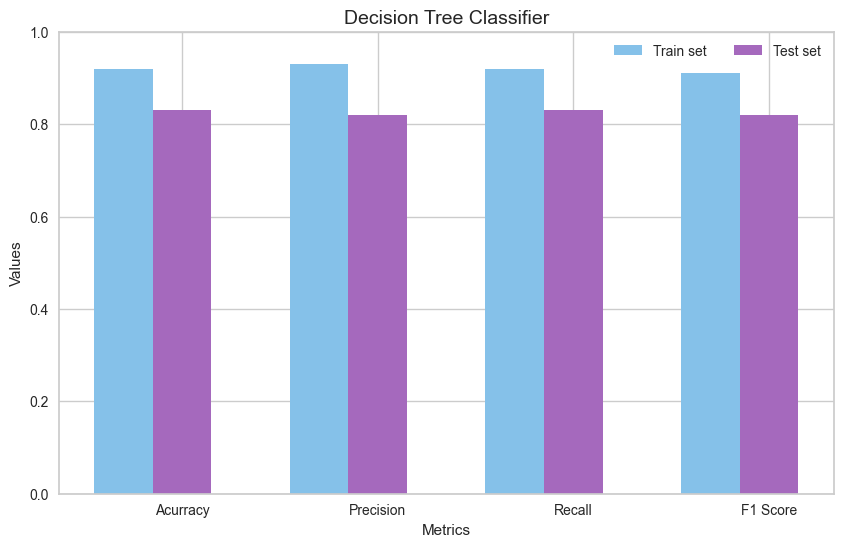

In [188]:
data = [
    ["Acurracy", 0.92, 0.83],
    ["Precision", 0.93, 0.82],
    ["Recall", 0.92, 0.83],
    ["F1 Score", 0.91, 0.82]
]
headers = ["Metrics", "Train set", "Test set"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_train = [row[1] for row in data]
values_test = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_train, width=bar_width, label=headers[1], color='#85C1E9')
plt.bar(index + bar_width, values_test, width=bar_width, label=headers[2], color='#A569BD')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Decision Tree Classifier', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend(ncol=2)
plt.ylim(0, 1.0)
plt.show()

+-----------+-------------+------------+
| Metrics   |   Train set |   Test set |
+===========+=============+============+
| Acurracy  |        0.98 |       0.8  |
+-----------+-------------+------------+
| Precision |        0.98 |       0.78 |
+-----------+-------------+------------+
| Recall    |        0.98 |       0.8  |
+-----------+-------------+------------+
| F1 Score  |        0.98 |       0.79 |
+-----------+-------------+------------+


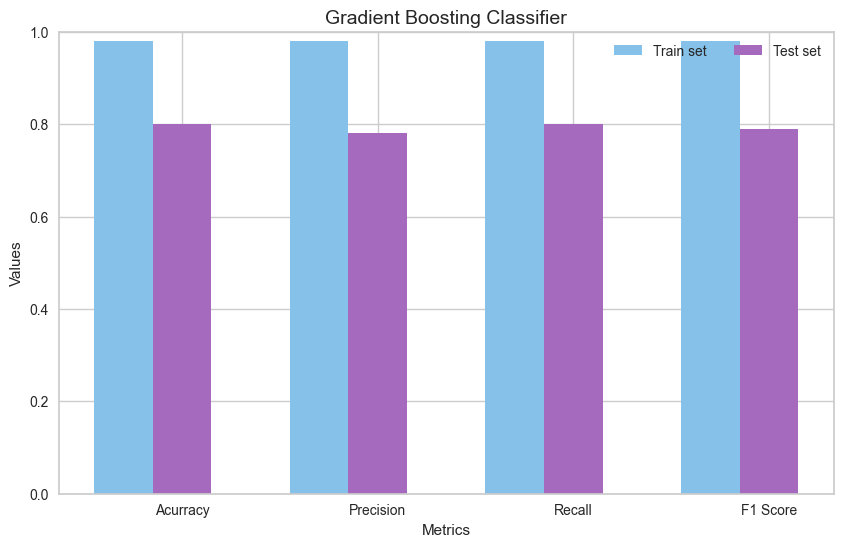

In [189]:
data = [
    ["Acurracy", 0.98, 0.80],
    ["Precision", 0.98, 0.78],
    ["Recall", 0.98, 0.80],
    ["F1 Score", 0.98, 0.79]
]
headers = ["Metrics", "Train set", "Test set"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_train = [row[1] for row in data]
values_test = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_train, width=bar_width, label=headers[1], color='#85C1E9')
plt.bar(index + bar_width, values_test, width=bar_width, label=headers[2], color='#A569BD')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Gradient Boosting Classifier', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend(ncol=2)
plt.ylim(0, 1.0)
plt.show()

+-----------+-------------+------------+
| Metrics   |   Train set |   Test set |
+===========+=============+============+
| Acurracy  |        0.94 |       0.83 |
+-----------+-------------+------------+
| Precision |        0.94 |       0.82 |
+-----------+-------------+------------+
| Recall    |        0.94 |       0.83 |
+-----------+-------------+------------+
| F1 Score  |        0.93 |       0.82 |
+-----------+-------------+------------+


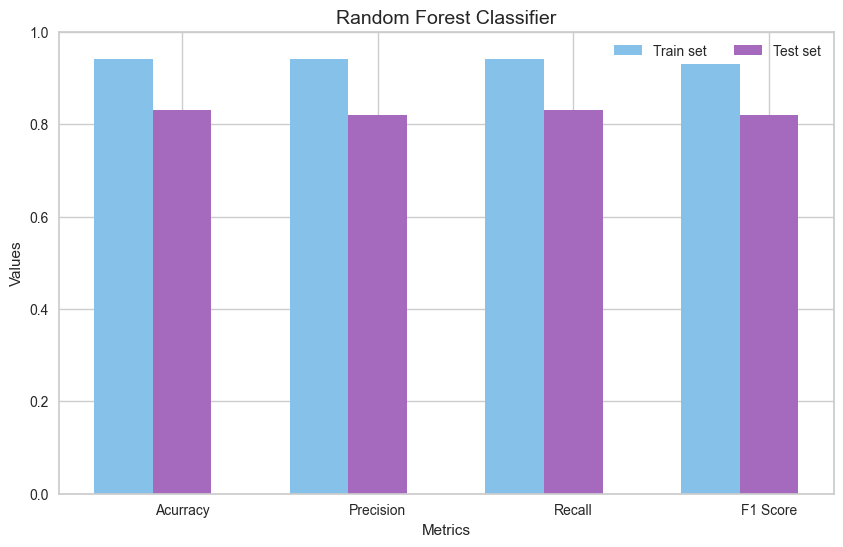

In [190]:
data = [
    ["Acurracy", 0.94, 0.83],
    ["Precision", 0.94, 0.82],
    ["Recall", 0.94, 0.83],
    ["F1 Score", 0.93, 0.82]
]
headers = ["Metrics", "Train set", "Test set"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_train = [row[1] for row in data]
values_test = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_train, width=bar_width, label=headers[1], color='#85C1E9')
plt.bar(index + bar_width, values_test, width=bar_width, label=headers[2], color='#A569BD')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Random Forest Classifier', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend(ncol=2)
plt.ylim(0, 1.0)
plt.show()

#### With SMOTE

In [192]:
X_train_resampled.shape, y_train_resampled.shape

((105, 3), (105,))

We can get accuracy of 0.9428571428571427 on the Train set using {'decisiontreeclassifier__random_state': 87, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'gini'}
Classifier: Decision Tree
Metrics for Train Set:
Accuracy: 0.80
Precision:" 0.86
Recall:" 0.80
F1 Score:" 0.81
Metrics for Test Set:
Accuracy:" 0.83
Precision:" 0.82
Recall:" 0.83
F1 Score:" 0.82


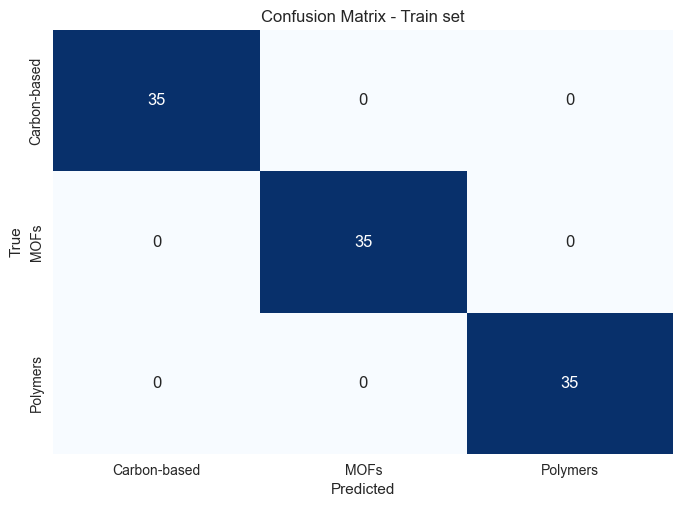

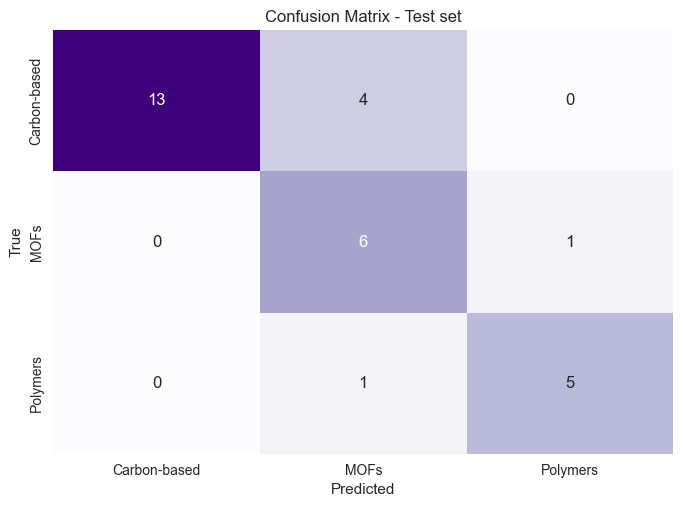

We can get accuracy of 0.9523809523809522 on the Train set using {'gradientboostingclassifier__subsample': 0.5, 'gradientboostingclassifier__random_state': 87, 'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__min_samples_split': 3, 'gradientboostingclassifier__min_samples_leaf': 4, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__learning_rate': 0.03}
Classifier: Gradient Boosting
Metrics for Train Set:
Accuracy: 0.80
Precision:" 0.80
Recall:" 0.80
F1 Score:" 0.80
Metrics for Test Set:
Accuracy:" 0.83
Precision:" 0.82
Recall:" 0.83
F1 Score:" 0.82


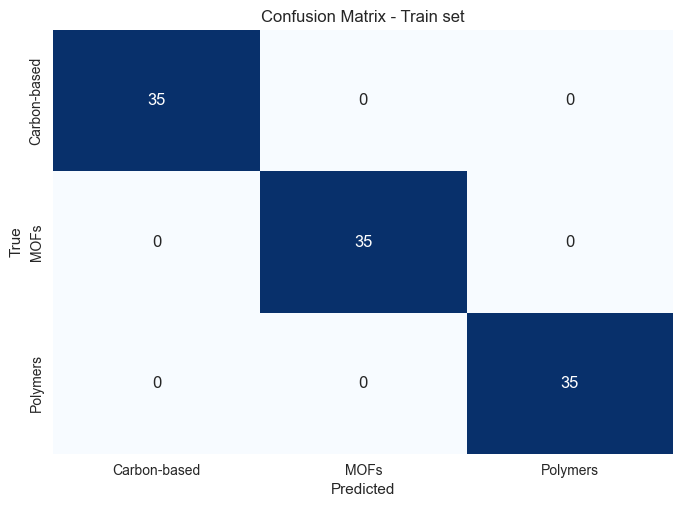

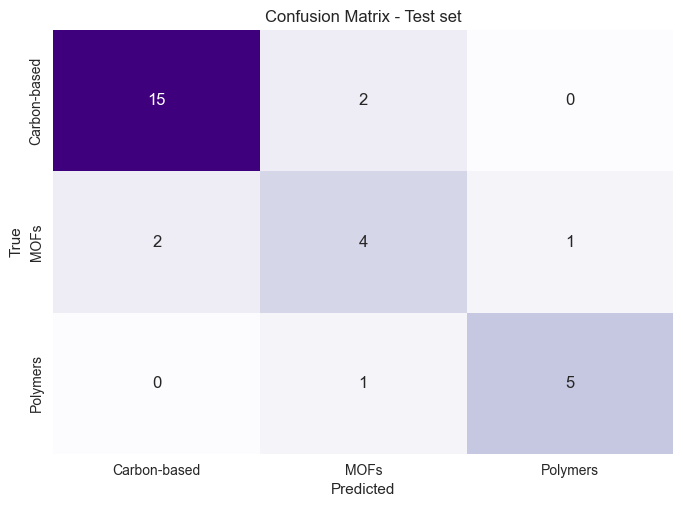

We can get accuracy of 0.9333333333333332 on the Train set using {'randomforestclassifier__random_state': 87, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'gini'}
Classifier: Random Forest
Metrics for Train Set:
Accuracy: 0.80
Precision:" 0.78
Recall:" 0.80
F1 Score:" 0.79
Metrics for Test Set:
Accuracy:" 0.83
Precision:" 0.82
Recall:" 0.83
F1 Score:" 0.82


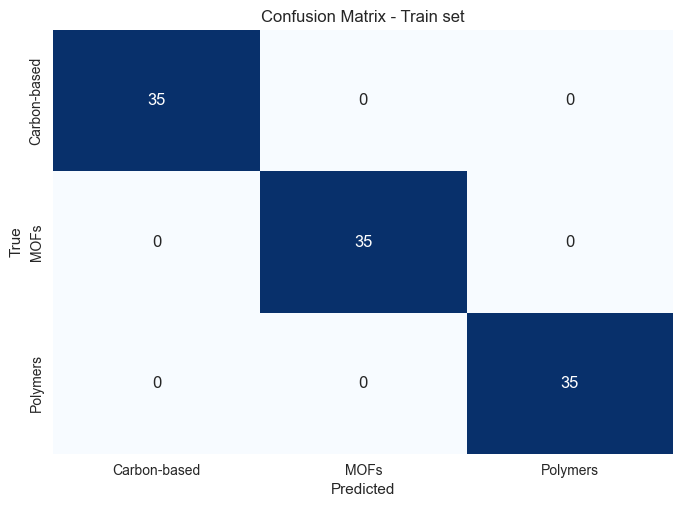

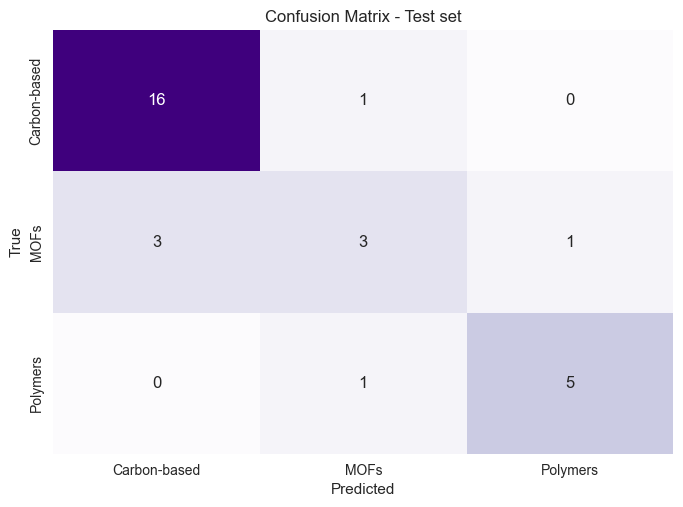

In [193]:
for name, clf in classifiers.items():
    pipe = make_pipeline(clf)
    random_search = RandomizedSearchCV(pipe, param_distributions=param_distributions[name], cv=skf, scoring='accuracy')
    random_search.fit(X_train_resampled, y_train_resampled)
    print('We can get accuracy of',random_search.best_score_,'on the Train set using',random_search.best_params_)
    
    # Train set metrics
    train_predictions_resampled = random_search.predict(X_train_resampled)
    train_accuracy_resampled = accuracy_score(y_train_resampled, train_predictions_resampled)
    train_precision_resampled = precision_score(y_train_resampled, train_predictions_resampled, average='weighted')
    train_recall_resampled = recall_score(y_train_resampled, train_predictions_resampled, average='weighted')
    train_f1_score_resampled = f1_score(y_train_resampled, train_predictions_resampled, average='weighted')
    
    # Test set metrics
    test_predictions = random_search.predict(X_test)
    test_accuracy_resampled = accuracy_score(y_test, test_predictions)
    test_precision_resampled = precision_score(y_test, test_predictions, average='weighted')
    test_recall_resampled = recall_score(y_test, test_predictions, average='weighted')
    test_f1_score_resampled = f1_score(y_test, test_predictions, average='weighted')

    print("Classifier:", name)
    print('Metrics for Train Set:')
    print(f'Accuracy: {test_accuracy_resampled:.2f}')
    print(f'Precision:" {test_precision_resampled:.2f}')
    print(f'Recall:" {test_recall_resampled:.2f}')
    print(f'F1 Score:" {test_f1_score_resampled:.2f}')
    
    print('Metrics for Test Set:')
    print(f'Accuracy:" {test_accuracy:.2f}')
    print(f'Precision:" {test_precision:.2f}')
    print(f'Recall:" {test_recall:.2f}')
    print(f'F1 Score:" {test_f1_score:.2f}')

    # Confusion Matrix for train set
    cm_test = confusion_matrix(y_train_resampled, train_predictions_resampled)
    sns.heatmap(cm_test, annot=True, cmap='Blues',
                xticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                yticklabels=['Carbon-based', 'MOFs', 'Polymers'], cbar=False)
    plt.title('Confusion Matrix - Train set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Confusion Matrix for test set
    cm_test = confusion_matrix(y_test, test_predictions)
    sns.heatmap(cm_test, annot=True, cmap='Purples',
                xticklabels=['Carbon-based', 'MOFs', 'Polymers'],
                yticklabels=['Carbon-based', 'MOFs', 'Polymers'], cbar=False)
    plt.title('Confusion Matrix - Test set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

+-----------+-------------+------------+
| Metrics   |   Train set |   Test set |
+===========+=============+============+
| Acurracy  |        0.8  |       0.83 |
+-----------+-------------+------------+
| Precision |        0.86 |       0.82 |
+-----------+-------------+------------+
| Recall    |        0.8  |       0.83 |
+-----------+-------------+------------+
| F1 Score  |        0.81 |       0.82 |
+-----------+-------------+------------+


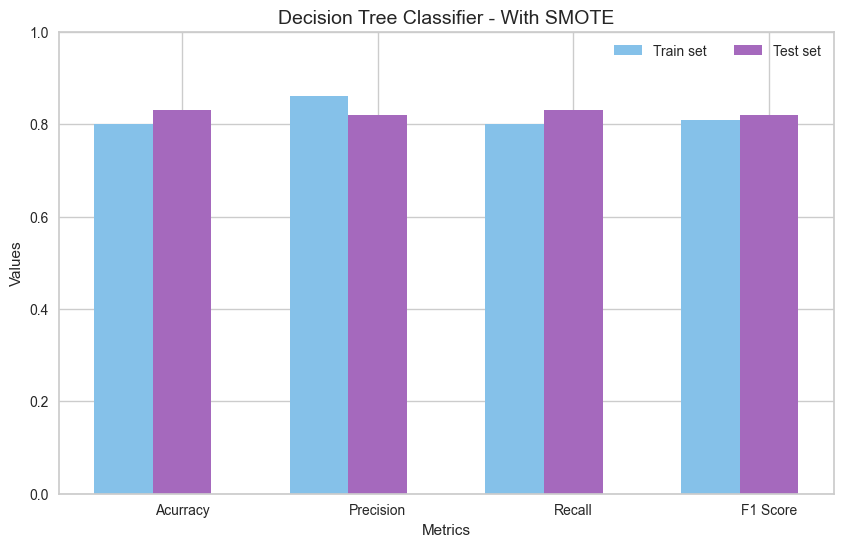

In [194]:
data = [
    ["Acurracy", 0.80, 0.83],
    ["Precision", 0.86, 0.82],
    ["Recall", 0.80, 0.83],
    ["F1 Score", 0.81, 0.82]
]
headers = ["Metrics", "Train set", "Test set"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_train = [row[1] for row in data]
values_test = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_train, width=bar_width, label=headers[1], color='#85C1E9')
plt.bar(index + bar_width, values_test, width=bar_width, label=headers[2], color='#A569BD')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Decision Tree Classifier - With SMOTE', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend(ncol=2)
plt.ylim(0, 1.0)
plt.show()

+-----------+-------------+------------+
| Metrics   |   Train set |   Test set |
+===========+=============+============+
| Acurracy  |         0.8 |       0.83 |
+-----------+-------------+------------+
| Precision |         0.8 |       0.82 |
+-----------+-------------+------------+
| Recall    |         0.8 |       0.83 |
+-----------+-------------+------------+
| F1 Score  |         0.8 |       0.82 |
+-----------+-------------+------------+


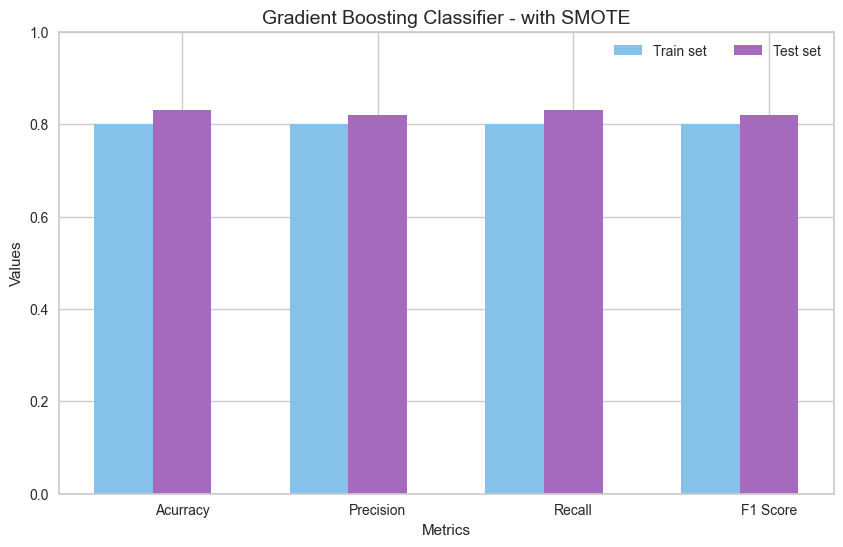

In [195]:
data = [
    ["Acurracy", 0.80, 0.83],
    ["Precision", 0.80, 0.82],
    ["Recall", 0.80, 0.83],
    ["F1 Score", 0.80, 0.82]
]
headers = ["Metrics", "Train set", "Test set"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_train = [row[1] for row in data]
values_test = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_train, width=bar_width, label=headers[1], color='#85C1E9')
plt.bar(index + bar_width, values_test, width=bar_width, label=headers[2], color='#A569BD')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Gradient Boosting Classifier - with SMOTE', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend(ncol=2)
plt.ylim(0, 1.0)
plt.show()

+-----------+-------------+------------+
| Metrics   |   Train set |   Test set |
+===========+=============+============+
| Acurracy  |        0.83 |       0.83 |
+-----------+-------------+------------+
| Precision |        0.82 |       0.82 |
+-----------+-------------+------------+
| Recall    |        0.83 |       0.83 |
+-----------+-------------+------------+
| F1 Score  |        0.82 |       0.82 |
+-----------+-------------+------------+


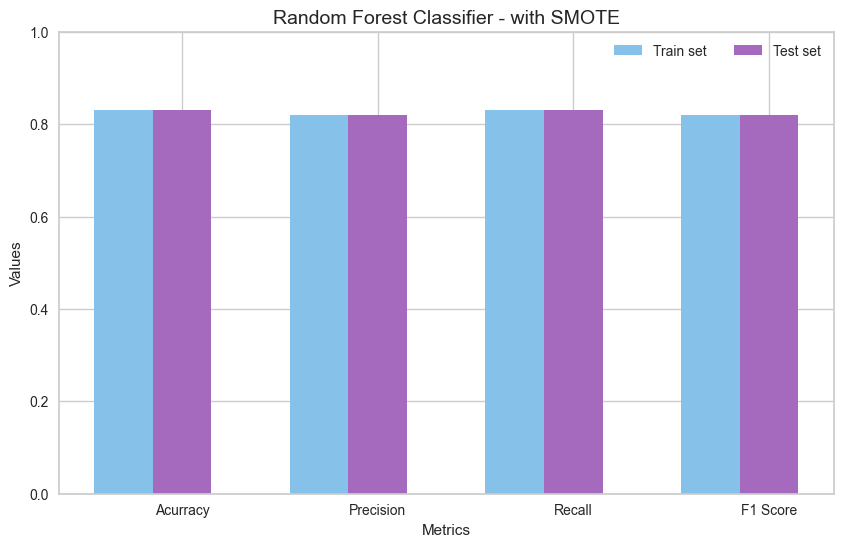

In [196]:
data = [
    ["Acurracy", 0.83, 0.83],
    ["Precision", 0.82, 0.82],
    ["Recall", 0.83, 0.83],
    ["F1 Score", 0.82, 0.82]
]
headers = ["Metrics", "Train set", "Test set"]
print(tabulate(data, headers=headers, tablefmt="grid"))

parameters = [row[0] for row in data]
values_train = [row[1] for row in data]
values_test = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_train, width=bar_width, label=headers[1], color='#85C1E9')
plt.bar(index + bar_width, values_test, width=bar_width, label=headers[2], color='#A569BD')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Random Forest Classifier - with SMOTE', fontsize=14)
plt.xticks(index + bar_width, parameters)
plt.legend(ncol=2)
plt.ylim(0, 1.0)
plt.show()

## Results validation

## Comparison

# Conclusion

# Future recommendations

### k-Nearest Neighbors (k-NN)
I choose to use this model because it can be applied to datasets with any number of classes and often gives a reasonable performance without complex adjustments (Müller and Guido, 2017, p.36,44).

Below, I will convert the array of the data standardized into a dataframe to posteriorly merge the columns dropped earlier. The new dataset will named 'df_ml'. 

In [81]:
array_data = np.array(scaled_data)
column_labels = ['BET surface area_m2/g', 'Total pore volume_cm3/g', 'CO2 uptake_mmol/g_25°C']
df_ar = pd.DataFrame(array_data, columns=column_labels)
df_ar.head()

,BET surface area_m2/g,Total pore volume_cm3/g,CO2 uptake_mmol/g_25°C
0,-0.700176,-1.254167,0.690000
1,0.000000,-0.629167,0.713333
2,0.188713,-0.295833,0.693333
3,0.604056,0.204167,0.570000
4,1.398589,0.537500,0.556667


In [82]:
df_ml = pd.merge(df_ar, df_encod[["Material_replace_0", "Material_replace_1", "Material_replace_2"]], left_index=True, right_index=True, how='left')
df_ml.head()

,BET surface area_m2/g,Total pore volume_cm3/g,CO2 uptake_mmol/g_25°C,Material_replace_0,Material_replace_1,Material_replace_2
0,-0.700176,-1.254167,0.690000,True,False,False
1,0.000000,-0.629167,0.713333,True,False,False
2,0.188713,-0.295833,0.693333,True,False,False
3,0.604056,0.204167,0.570000,True,False,False
4,1.398589,0.537500,0.556667,True,False,False


Now, I will prepare the data to split for performing the k-NN.

The target variable will be the 'Material_replace' because I want to identify which material can be suitable given a certain amount of CO<sub>2</sub> uptake desired by the industry. 

First, I will define the X and y variables. Then, I used the 'idxmax' to flatten the target variable without introducing different weights to the classes.

In [84]:
X = df_ml.drop(["Material_replace_0", "Material_replace_1", "Material_replace_2"], axis=1)
y = df_ml[["Material_replace_0", "Material_replace_1", "Material_replace_2"]]

y = y.idxmax(axis=1)

I will Split the data into train and test sets.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45, 3), (12, 3), (45,), (12,))

I will initialize the k-NN classifiers and then use the Cross-Validation to reduce the possibility of bias in the model performance, as it is a statistical method used to assess the performance of a machine learning model by splitting the dataset into multiple subsets (folds) that will be trained and evaluating the model on different combinations of these folds (Müller and Guido, 2017, p.253).

In [88]:
knn = KNeighborsClassifier(n_neighbors=3, metric="manhattan")

y_pred_train = cross_val_predict(knn, X_train, y_train, cv=5)

I will fit the model on the training set and make predictions on the test set.

In [90]:
knn.fit(X_train, y_train)

y_pred_test = knn.predict(X_test)

###### Metrics for training set

I will calculate the metrics (accuracy, precision, recall and F1-score) for the training and test set to evaluate the models' performance. I will also use the "average='weighted'" to ensure that the metrics will not dominate in the majority class compared to the minority because there is a slight difference between the classes, and as I am using a small dataset, it could make a significant difference.

Metrics for Training set:
Accuracy: 0.7778
Precision: 0.7760
Recall: 0.7778
F1 Score: 0.7703

Confusion Matrix:


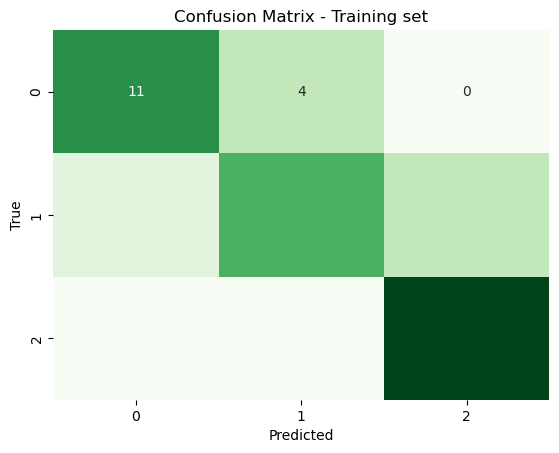

In [93]:
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print("Metrics for Training set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")
print("\nConfusion Matrix:")

cm_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.title('Confusion Matrix - Training set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###### Metrics for test set


Metrics for Test set:
Accuracy: 0.6667
Precision: 0.8889
Recall: 0.6667
F1 Score: 0.6667

Confusion Matrix:


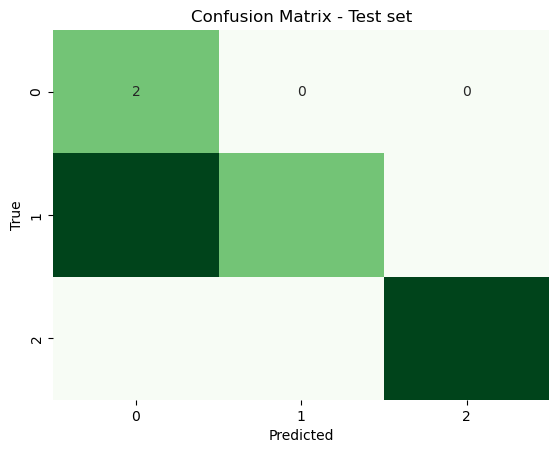

In [95]:
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print("\nMetrics for Test set:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print("\nConfusion Matrix:")

cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.title('Confusion Matrix - Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Evaluation - kNN

+------------+---------+--------+
| 10% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |  0.7451 | 0.8333 |
+------------+---------+--------+
| Precision  |  0.7489 | 0.9167 |
+------------+---------+--------+
| Recall     |  0.7451 | 0.8333 |
+------------+---------+--------+
| F1 Score   |  0.7348 | 0.8333 |
+------------+---------+--------+
+------------+---------+--------+
| 20% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |  0.7111 | 0.6667 |
+------------+---------+--------+
| Precision  |  0.704  | 0.8889 |
+------------+---------+--------+
| Recall     |  0.7111 | 0.6667 |
+------------+---------+--------+
| F1 Score   |  0.6978 | 0.6667 |
+------------+---------+--------+
+------------+---------+--------+
| 30% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |  0.7436 | 0.5556 |
+------------+---------+--------+
| Precision  |  0.7433 | 0.7389 |
+------------+---------+--------+
| Recall     |

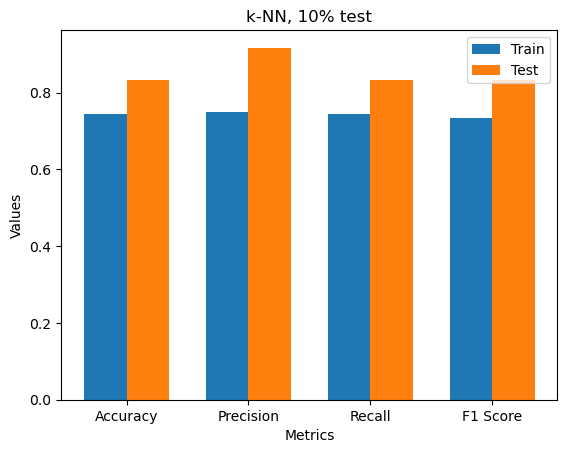

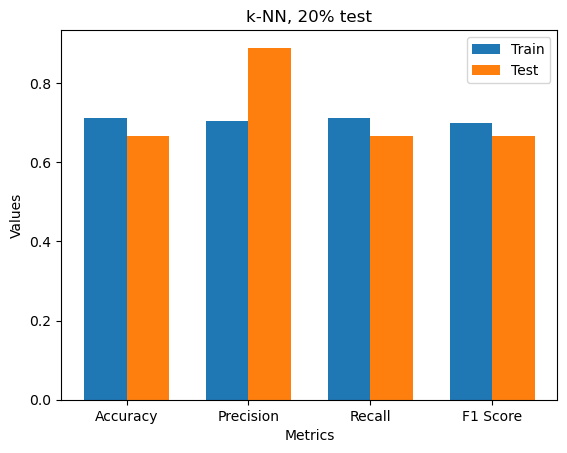

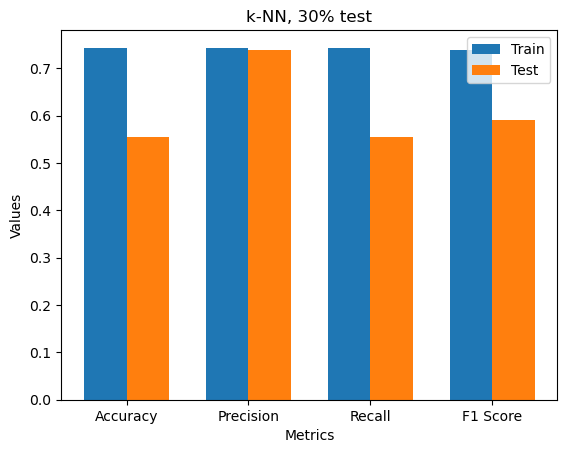

In [97]:
data = [
    ["Accuracy", 0.7451, 0.8333],
    ["Precision", 0.7489, 0.9167],
    ["Recall", 0.7451, 0.8333],
    ["F1 Score", 0.7348, 0.8333],
]   
headers = ["10% test", "Train", "Test"]

data1 = [
    ["Accuracy", 0.7111, 0.6667],
    ["Precision", 0.7040, 0.8889],
    ["Recall", 0.7111, 0.6667],
    ["F1 Score", 0.6978, 0.6667],
]   
headers1 = ["20% test", "Train", "Test"]

data2 = [
    ["Accuracy", 0.7436, 0.5556],
    ["Precision", 0.7433, 0.7389],
    ["Recall", 0.7436, 0.5556],
    ["F1 Score", 0.7384, 0.5915],
]   
headers2 = ["30% test", "Train", "Test"]
print(tabulate(data, headers=headers, tablefmt="grid"))
print(tabulate(data1, headers=headers1, tablefmt="grid"))
print(tabulate(data2, headers=headers2, tablefmt="grid"))

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, label="Test")

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(data, headers, "k-NN, 10% test")
plot_data(data1, headers1, "k-NN, 20% test")
plot_data(data2, headers2, "k-NN, 30% test")

Using the default parameters, I obtained overfitting in all metrics when I split the test into 10%. In 20%, it happened only in the precision metric, meaning that the model memorised the positive instances but generalised well when considering the other metrics. The same occurred in the 30% split but with more differences between the training and test sets; however, these results decreased compared to the 20%. Because of this, I will use the 20% percentage split for the hyperparameters adjustment in the next step.

#### Adjusting hyperparameters

Now, I will focus on the 20% test split to assess the hyperparameters in this model to try to improve the model's performance.

The k-NN classifier has two essential parameters: the number of neighbors and the distance measurement between data points (Müller and Guido, 2017, p.44). Regarding the number of neighbours (chart below), I found that the number 3 is the best in this case because it is reasonably accurate and is not overfitted. 

Considering the distance measurement, they resulted in reasonable accuracy and generalization. The distance metric did not influence the test set; however, Manhattan performed better than the other metrics in the training set (chart below).

+---------------------+---------+--------+
|   Accuracy, 20%test |   Train |   Test |
+=====================+=========+========+
|                   1 |  0.6889 | 0.75   |
+---------------------+---------+--------+
|                   2 |  0.6    | 0.5833 |
+---------------------+---------+--------+
|                   3 |  0.7111 | 0.6667 |
+---------------------+---------+--------+
|                   4 |  0.6444 | 0.5833 |
+---------------------+---------+--------+
|                   5 |  0.7111 | 0.6667 |
+---------------------+---------+--------+


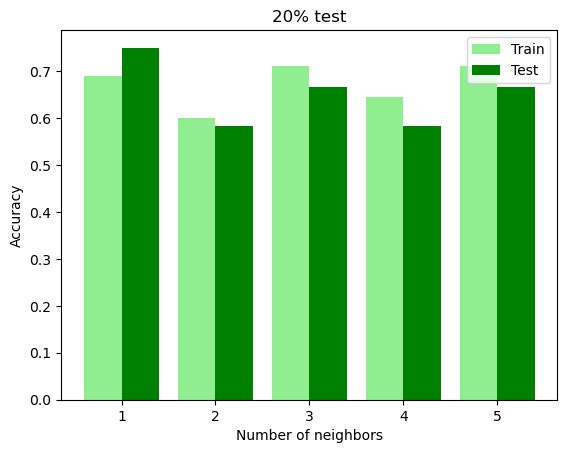

In [101]:
data = [
    ["1", 0.6889, 0.7500],
    ["2", 0.6000, 0.5833],
    ["3", 0.7111, 0.6667],
    ["4", 0.6444, 0.5833],
    ["5", 0.7111, 0.6667],
]   
headers = ["Accuracy, 20%test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.4
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, color="lightgreen", label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, color="green", label="Test")

    ax.set_xlabel("Number of neighbors")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(data, headers, "20% test")

+---------------------+---------+--------+
| Accuracy, 30%test   |   Train |   Test |
+=====================+=========+========+
| euclidean           |  0.7111 | 0.6667 |
+---------------------+---------+--------+
| manhattan           |  0.7778 | 0.6667 |
+---------------------+---------+--------+
| chebyshev           |  0.7111 | 0.6667 |
+---------------------+---------+--------+


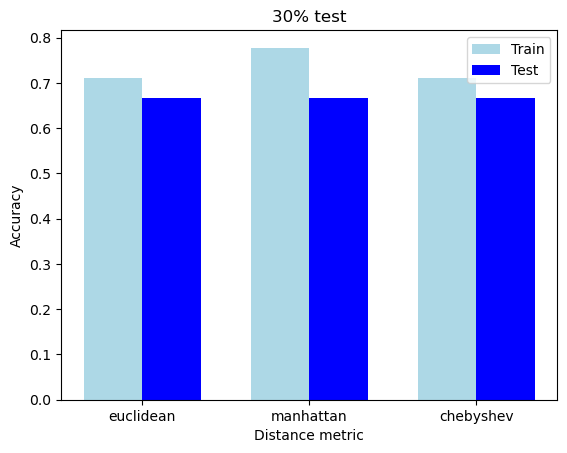

In [102]:
data = [
    ["euclidean", 0.7111, 0.6667],
    ["manhattan", 0.7778, 0.6667],
    ["chebyshev", 0.7111, 0.6667],
]   
headers = ["Accuracy, 30%test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, color="lightblue", label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, color="blue", label="Test")

    ax.set_xlabel("Distance metric")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(data, headers, "30% test")

The chart below shows that using the 'manhattan' distance metric, the training set slightly improved compared to 'euclidean' and 'chebyshev' metrics. Therefore, at the moment, it is the best set that I could achieve with these adjustments.

+------------+---------+--------+
| 20% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |  0.7778 | 0.6667 |
+------------+---------+--------+
| Precision  |  0.7766 | 0.8889 |
+------------+---------+--------+
| Recall     |  0.7778 | 0.6667 |
+------------+---------+--------+
| F1 Score   |  0.7703 | 0.6667 |
+------------+---------+--------+


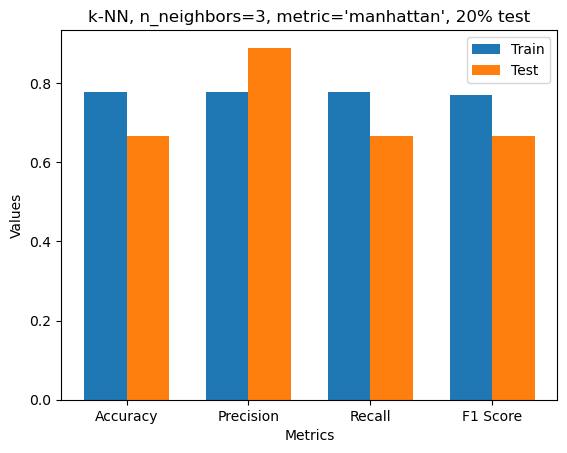

In [104]:
data = [
    ["Accuracy", 0.7778, 0.6667],
    ["Precision", 0.77660, 0.8889],
    ["Recall", 0.7778, 0.6667],
    ["F1 Score", 0.7703, 0.6667],
]   
headers = ["20% test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))


def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, label="Test")

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(data, headers, "k-NN, n_neighbors=3, metric='manhattan', 20% test")

## kNN - SMOTE 

The Synthetic Minority Over-sampling Technique (SMOTE) is an algorithm that can be used to generate synthetic data to provide new related information on the positive class to the learning algorithm (Chawla, 2009, p.880).

I will use the SMOTE balance the classes and try to imporeve the models performanceI will use the SMOTE to balance the classes and try to improve the k-NN's performance.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45, 3), (12, 3), (45,), (12,))

I am Applying SMOTE to the training set only. If I apply it to the entire dataset, it will result in an overfit of the negative class, which will generate excellent metrics but not in accordance with the real dataset.

In [108]:
smote = SMOTE(random_state=51)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled.shape, y_train_resampled.shape

((48, 3), (48,))

I will use the code below to call the Gradient Boosting Classifier with the data balanced (SMOTE), and then I will train the model using the training sets and make predictions on the test set.

In [110]:
knn_smote = KNeighborsClassifier(n_neighbors=3, metric="manhattan")

y_train_pred = cross_val_predict(knn_smote, X_train_resampled, y_train_resampled, cv=5)

In [111]:
knn_smote.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

Making predictions on the test set.

In [113]:
y_pred_smote_knn = knn_smote.predict(X_test)

####  Metrics - SMOTE - kNN

In [115]:
print( "Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred_smote_knn)) )
print( "precision: {:.2f}".format(metrics.precision_score(y_test, y_pred_smote_knn, average='weighted')) )
print( "recall: {:.2f}".format(metrics.recall_score(y_test, y_pred_smote_knn, average='weighted')) )
print( "F1 Score: {:.2f}".format(metrics.f1_score(y_test, y_pred_smote_knn, average='weighted')) )

Accuracy: 0.67
precision: 0.57
recall: 0.67
F1 Score: 0.61


C:\Users\danie\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


####  Accuracy - SMOTE - kNN - train and test

In [117]:
print("Training Accuracy :", knn_smote.score(X_train, y_train))
print("Testing Accuracy :", knn_smote.score(X_test, y_test))

Training Accuracy : 0.8444444444444444
Testing Accuracy : 0.6666666666666666


Text(50.72222222222221, 0.5, 'Actual')

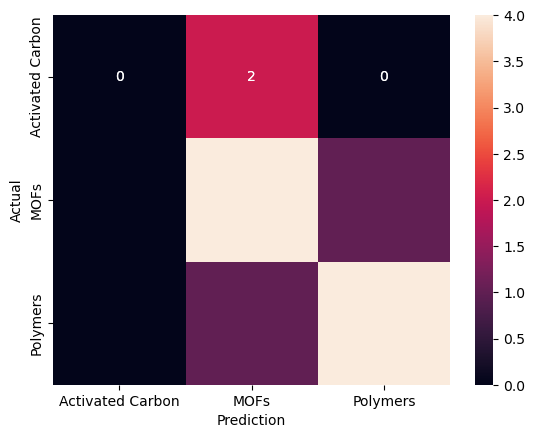

In [118]:
cm = confusion_matrix(y_test, y_pred_smote_knn)
sns.heatmap(cm, annot=True)
ax = sns.heatmap(cm, annot=True,                  
                 xticklabels=['Activated Carbon', 'MOFs', 'Polymers'],                
                 yticklabels=['Activated Carbon', 'MOFs', 'Polymers'],                  
                 cbar=False)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

After applying the SMOTE in the k-NN model, I realized that this tool did not promote enhancements in the model performance. Inclusive seems overfitting because the training accuracy is too high (0.84) and the test is not (0.67). Generally, it indicates that the training set learned the data too well, including its noises, and performs poorly in new data. 

### Gradient boosted regression trees
I chose to use this model as an alternative to k-NN, which did not improve after extensive adjustments.

Gradient Boosting is considered a powerful model due to its approach to building serial trees that try to correct the mistakes of the previous one; in addition, it is more sensitive than random forest and can provide better accuracy with the correct setting (Müller and Guido, 2017, p.88,89).

I will use the scaled data because there is no difference in the model's performance between scaled and non-scaled data. 

I will prepare the data to split for performing the Gradient Boosting.

First, I will define the X and y variables. Then, I used the 'idxmax' to flatten the target variable without introducing different weights to the classes.

In [122]:
X = df_ml.drop(["Material_replace_0", "Material_replace_1", "Material_replace_2"], axis=1)
y = df_ml[["Material_replace_0", "Material_replace_1", "Material_replace_2"]]

y = y.idxmax(axis=1)

I will Split the data into train and test sets.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45, 3), (12, 3), (45,), (12,))

I will initialize the Gradient Boosting classifiers and then use the Cross-Validation as I did in the previous model. 

In [126]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=2, random_state=12)

y_train_pred = cross_val_predict(gb_clf, X_train, y_train, cv=5)

I will fit the model on the training set and make predictions on the training and test set.

In [128]:
gb_clf.fit(X_train, y_train)

y_train_pred = gb_clf.predict(X_train)

y_test_pred = gb_clf.predict(X_test)

###### Metrics for training set

Training Set Metrics:
Accuracy: 0.9555555555555556
Precision: 0.960233918128655
Recall: 0.9555555555555556
F1-Score: 0.9549382716049383


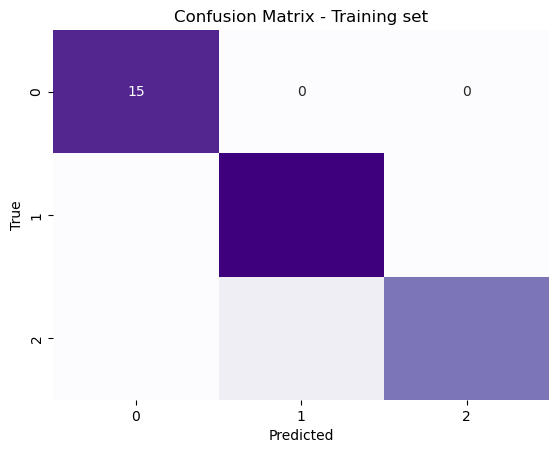

In [130]:
print("Training Set Metrics:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred, average='weighted'))
print("Recall:", recall_score(y_train, y_train_pred, average='weighted'))
print("F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))

cm_test = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', cbar=False)
plt.title('Confusion Matrix - Training set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

###### Metrics for test set


Test Set Metrics:
Accuracy: 0.75
Precision: 0.8571428571428571
Recall: 0.75
F1-Score: 0.7424242424242425


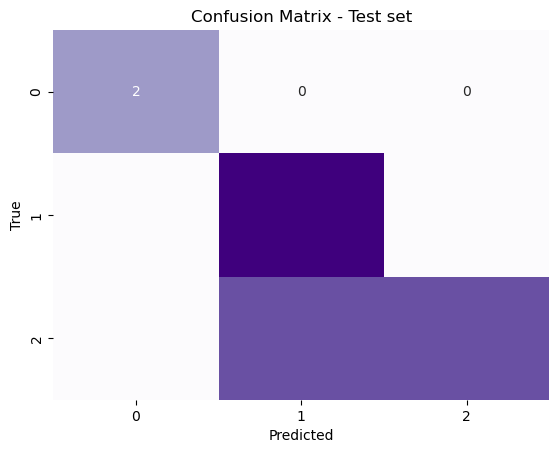

In [132]:
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_test_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', cbar=False)
plt.title('Confusion Matrix - Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Feature importances

The Gradient Boosting provides feature importance as the decision tree-based models because it is impractical to visualize at least 100 trees (default) (Müller and Guido, 2017, p.90). 

The chart below shows which features contribute the most to the model's predictions.

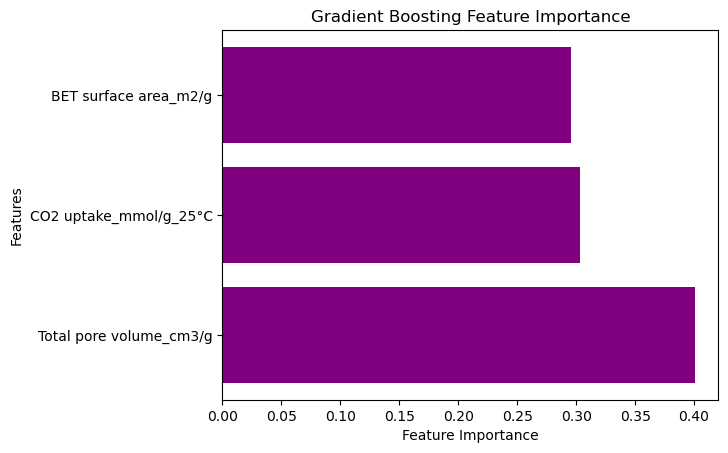

In [134]:
feature_imp = pd.Series(gb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
bar_color = 'purple'
plt.barh(feature_imp.index, feature_imp, color=bar_color)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Feature Importance')
plt.show()

As we can see on the chart above, the 'Total pore volume' is the feature most relevant to the models' performance, followed by the 'CO2 uptake' and 'BET surface area'.

## Evaluation - Gradient Boosting (GB)

+------------+---------+--------+
| 10% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |       1 |      1 |
+------------+---------+--------+
| Precision  |       1 |      1 |
+------------+---------+--------+
| Recall     |       1 |      1 |
+------------+---------+--------+
| F1 Score   |       1 |      1 |
+------------+---------+--------+
+------------+---------+--------+
| 20% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |       1 |  0.75  |
+------------+---------+--------+
| Precision  |       1 |  0.857 |
+------------+---------+--------+
| Recall     |       1 |  0.75  |
+------------+---------+--------+
| F1 Score   |       1 |  0.74  |
+------------+---------+--------+
+------------+---------+--------+
| 30% test   |   Train |   Test |
+============+=========+========+
| Accuracy   |       1 | 0.6666 |
+------------+---------+--------+
| Precision  |       1 | 0.6879 |
+------------+---------+--------+
| Recall     |

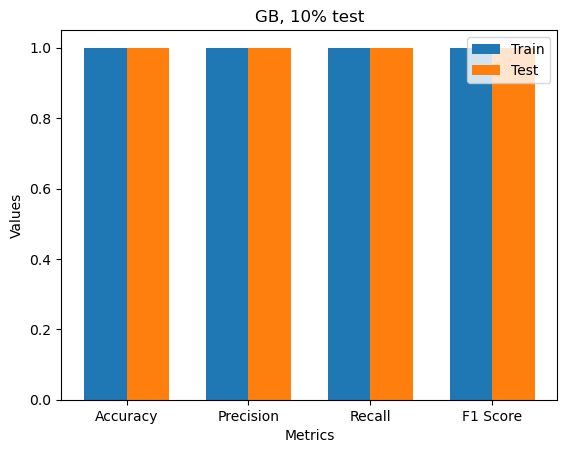

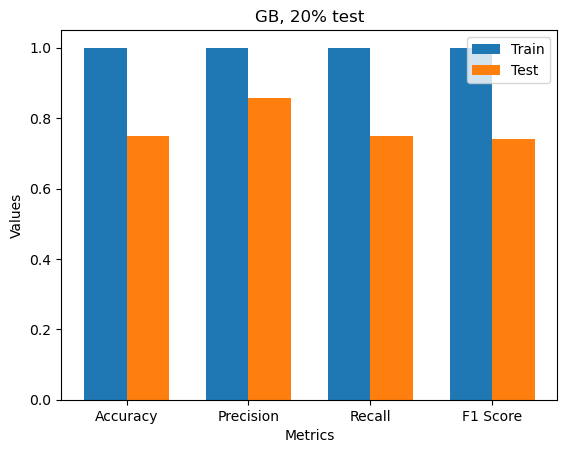

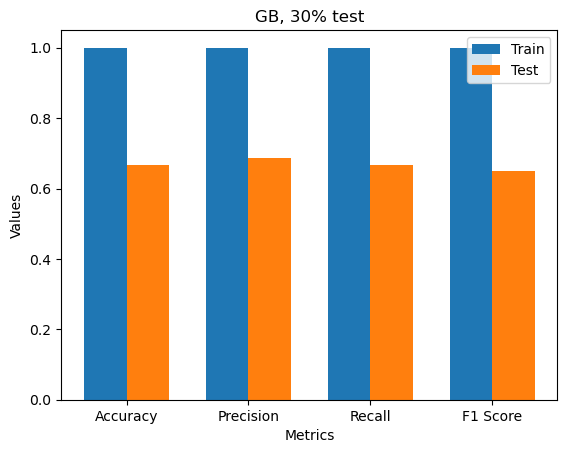

In [137]:
data = [
    ["Accuracy", 1.0, 1.0],
    ["Precision", 1.0, 1.0],
    ["Recall", 1.0, 1.0],
    ["F1 Score", 1.0, 1.0],
]   
headers = ["10% test", "Train", "Test"]

data1 = [
    ["Accuracy", 1.0, 0.75],
    ["Precision", 1.0, 0.857],
    ["Recall", 1.0, 0.75],
    ["F1 Score", 1.0, 0.74],
]   
headers1 = ["20% test", "Train", "Test"]

data2 = [
    ["Accuracy", 1.0, 0.6666],
    ["Precision", 1.0, 0.6879],
    ["Recall", 1.0, 0.6666],
    ["F1 Score", 1.0, 0.6508],
]   
headers2 = ["30% test", "Train", "Test"]
print(tabulate(data, headers=headers, tablefmt="grid"))
print(tabulate(data1, headers=headers1, tablefmt="grid"))
print(tabulate(data2, headers=headers2, tablefmt="grid"))

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, label="Test")

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(data, headers, "GB, 10% test")
plot_data(data1, headers1, "GB, 20% test")
plot_data(data2, headers2, "GB, 30% test")

The Gradient Boosting presented better performance than the k-NN model; however, the training set is likely to be overfitting because its accuracy is 100%, but when we see the test set, the split of 20% provided better metrics than the other. Thus, I will focus on the 20% test split for hyperparameters adjustment. 

In the next step, I will adjust hyperparameters like learning_rate that controls how strong each tree makes corrections of the previous trees, as well as the n_estimators and maximum depth that are the main parameters for this model (Müller and Guido, 2017, p.89,91). 

#### Adjusting hyperparameters

In [140]:
data = [
    ["Accuracy", 1.0, 0.67],
    ["Precision", 1.0, 0.71],
    ["Recall", 1.0, 0.67],
    ["F1 Score", 1.0, 0.67],
]   
headers = ["max_depth=1, n_estimators=100, learning_rate=0.1, 20% test", "Train", "Test"]

data1 = [
    ["Accuracy", 1.0, 0.75],
    ["Precision", 1.0, 0.86],
    ["Recall", 1.0, 0.75],
    ["F1 Score", 1.0, 0.74],
]   
headers1 = ["max_depth=2, n_estimators=100, learning_rate=0.1, 20% test", "Train", "Test"]

data2 = [
    ["Accuracy", 1.0, 0.67],
    ["Precision", 1.0, 0.78],
    ["Recall", 1.0, 0.67],
    ["F1 Score", 1.0, 0.67],
]   
headers2 = ["max_depth=3, n_estimators=100, learning_rate=0.1, 20% test", "Train", "Test"]

data3 = [
    ["Accuracy", 1.0, 0.75],
    ["Precision", 1.0, 0.68],
    ["Recall", 1.0, 0.75],
    ["F1 Score", 1.0, 0.74],
]   
headers3 = ["max_depth=4, n_estimators=100, learning_rate=0.1, 20% test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))
print(tabulate(data1, headers=headers1, tablefmt="grid"))
print(tabulate(data2, headers=headers2, tablefmt="grid"))
print(tabulate(data3, headers=headers3, tablefmt="grid"))


+--------------------------------------------------------------+---------+--------+
| max_depth=1, n_estimators=100, learning_rate=0.1, 20% test   |   Train |   Test |
+==============================================================+=========+========+
| Accuracy                                                     |       1 |   0.67 |
+--------------------------------------------------------------+---------+--------+
| Precision                                                    |       1 |   0.71 |
+--------------------------------------------------------------+---------+--------+
| Recall                                                       |       1 |   0.67 |
+--------------------------------------------------------------+---------+--------+
| F1 Score                                                     |       1 |   0.67 |
+--------------------------------------------------------------+---------+--------+
+--------------------------------------------------------------+---------+--

The table above shows that the train set was overfitted for all 'max_depth' tested. However, the minimum 'max_depth=2' achieved the best values for the metrics in the test set, and this information will be used to evaluate if changing the 'learning_rate' will be possible to find better metrics inclusive for the training set.

+--------------------------------------------------------------+---------+--------+
| max_depth=2, n_estimators=100, learning_rate=0.1, 20% test   |   Train |   Test |
+==============================================================+=========+========+
| Accuracy                                                     |       1 |   0.75 |
+--------------------------------------------------------------+---------+--------+
| Precision                                                    |       1 |   0.86 |
+--------------------------------------------------------------+---------+--------+
| Recall                                                       |       1 |   0.75 |
+--------------------------------------------------------------+---------+--------+
| F1 Score                                                     |       1 |   0.74 |
+--------------------------------------------------------------+---------+--------+
+---------------------------------------------------------------+---------+-

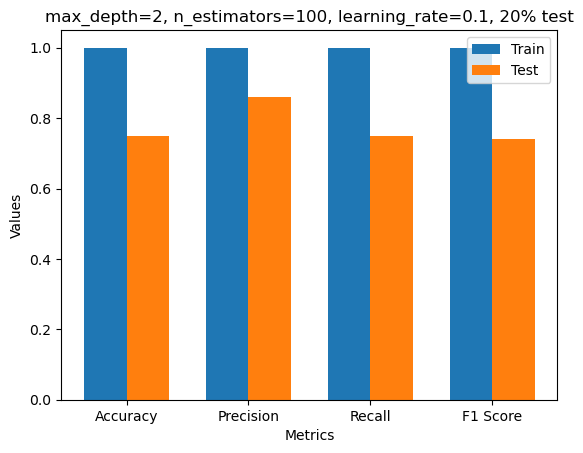

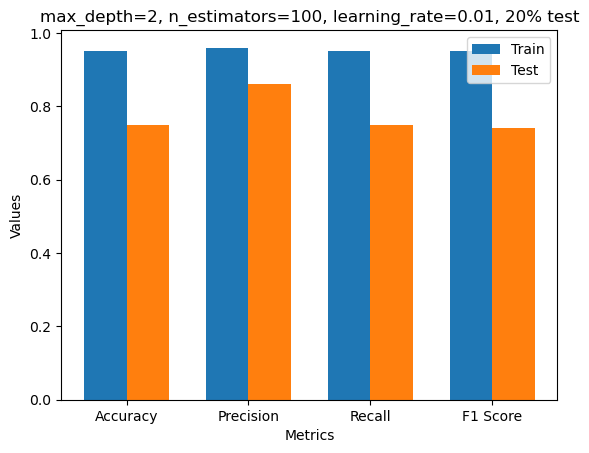

In [142]:
data = [
    ["Accuracy", 1.0, 0.75],
    ["Precision", 1.0, 0.86],
    ["Recall", 1.0, 0.75],
    ["F1 Score", 1.0, 0.74],
]   
headers = ["max_depth=2, n_estimators=100, learning_rate=0.1, 20% test", "Train", "Test"]

data1 = [
    ["Accuracy", 0.95, 0.75],
    ["Precision", 0.96, 0.86],
    ["Recall", 0.95, 0.75],
    ["F1 Score", 0.95, 0.74],
]   
headers1 = ["max_depth=2, n_estimators=100, learning_rate=0.01, 20% test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))
print(tabulate(data1, headers=headers1, tablefmt="grid"))

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, label="Test")

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()

plot_data(data, headers, "max_depth=2, n_estimators=100, learning_rate=0.1, 20% test")
plot_data(data1, headers1, "max_depth=2, n_estimators=100, learning_rate=0.01, 20% test")

As we can see on the table and charts above the 'learning_rate=0.01' resulted in a model that is can generalize well without overfitting.

## Models assessment

Now, I will compare the two models (k-NN and GB), considering the best setting obtained for each one.

The chart below shows that despite the trials to improve the k-NN models' performance, it resulted in poorly performance in both training and test sets, meaning that this model is not capable of generalising well because it is underfitting, probability because the model is basic and the amount of data is too small.

Regarding the Gradient Boosting, we can see a significant improvement in comparison with k-NN, mainly for the accuracy that increased 17.22% in the training set and 8.33% in the test set. It suggests that this model can generalise well; however, the test set has room for improvement. In addition, the 'Total pore volume'  was the feature that contributed most to the model's predictions, followed by the 'CO2 uptake' and 'BET surface area'.

+-----------+--------+------+
| Metrics   |   k-NN |   GB |
+===========+========+======+
| Acc_Tr    | 0.7778 | 0.95 |
+-----------+--------+------+
| Acc_Te    | 0.6667 | 0.75 |
+-----------+--------+------+
| Prec_Tr   | 0.7766 | 0.96 |
+-----------+--------+------+
| Prec_Te   | 0.8889 | 0.86 |
+-----------+--------+------+
| Rec_Tr    | 0.7778 | 0.95 |
+-----------+--------+------+
| Rec_Te    | 0.6667 | 0.75 |
+-----------+--------+------+
| F1_Tr     | 0.7703 | 0.95 |
+-----------+--------+------+
| F1_Te     | 0.6667 | 0.74 |
+-----------+--------+------+
k-NN: n_neighbors=3, metric='manhattan', 20% test
GB: max_depth=2, n_estimators=100, learning_rate=0.01, 20% test


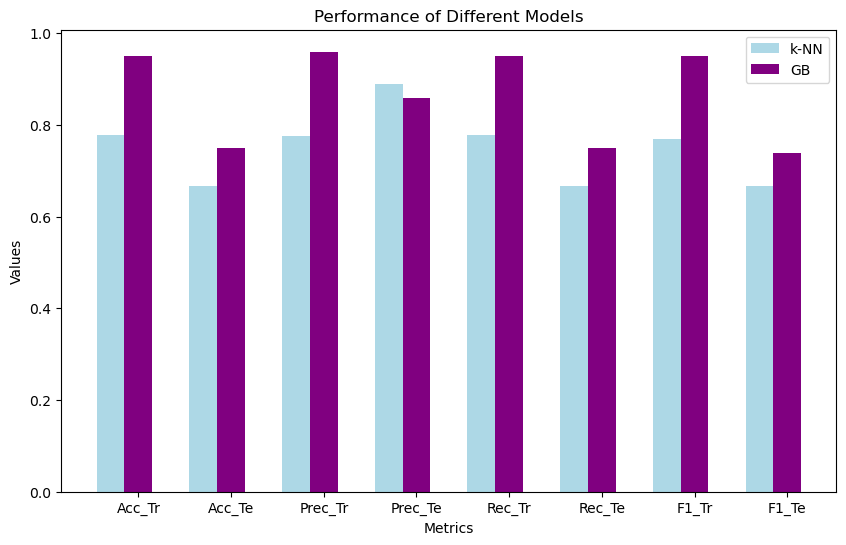

In [146]:
data = [
    ["Acc_Tr", 0.7778, 0.95],
    ["Acc_Te", 0.6667, 0.75],
    ["Prec_Tr", 0.7766, 0.96],
    ["Prec_Te", 0.8889, 0.86],
    ["Rec_Tr", 0.7778, 0.95],
    ["Rec_Te", 0.6667, 0.75],
    ["F1_Tr", 0.7703, 0.95],
    ["F1_Te", 0.6667, 0.74],
]
headers = ["Metrics", "k-NN", "GB"]
print(tabulate(data, headers=headers, tablefmt="grid"))
print("k-NN: n_neighbors=3, metric='manhattan', 20% test")
print("GB: max_depth=2, n_estimators=100, learning_rate=0.01, 20% test")

parameters = [row[0] for row in data]
values_kNN = [row[1] for row in data]
values_GB = [row[2] for row in data]

bar_width = 0.3
index = np.arange(len(parameters))
figsize = (10,6)
plt.figure(figsize=figsize)

plt.bar(index, values_kNN, width=bar_width, label=headers[1], color='lightblue')
plt.bar(index + bar_width, values_GB, width=bar_width, label=headers[2], color='purple')
#plt.bar(index + 2 * bar_width, values_RF_PCA, width=bar_width, label=headers[3])

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance of Different Models')
plt.xticks(index + bar_width, parameters)
plt.legend()
plt.show()

## Grid Search to Find Optimal Hyperparameters - GB

In [148]:
param_grid = {
    'n_estimators': [100, 150, 200, 1000],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [1, 2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [1, 2, 3, 4], 
    'min_samples_split': [2, 3],
    'subsample': [0.1, 0.3, 0.5, 0.8]
}
# Create a based model
gb_clf = GradientBoostingClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1)

The code below fits the grid search to the data. As running takes a lot of time, I used the # simbol to avoid it.  

In [150]:
#grid_search.fit(X_train, y_train)

Below will print the optimal accuracy score and hyperparameters

In [152]:
#print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45, 3), (12, 3), (45,), (12,))

In [154]:
gb_clf = GradientBoostingClassifier(learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1, random_state=12)

y_train_pred = cross_val_predict(gb_clf, X_train, y_train, cv=5)

In [155]:
gb_clf.fit(X_train, y_train)

y_train_pred = gb_clf.predict(X_train)

y_test_pred = gb_clf.predict(X_test)

Training Set Metrics:
Accuracy: 0.7777777777777778
Precision: 0.7768416768416769
Recall: 0.7777777777777778
F1-Score: 0.7700710811821924


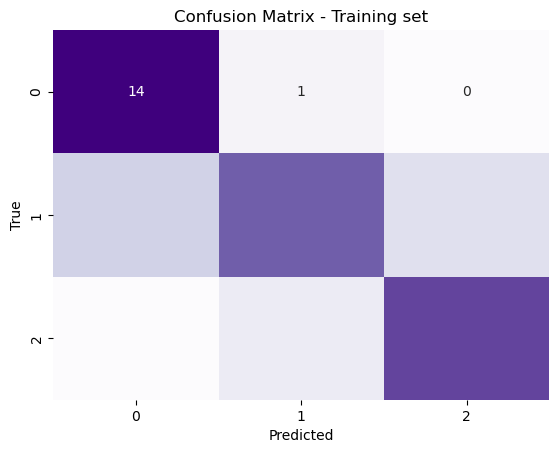

In [156]:
print("Training Set Metrics:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred, average='weighted'))
print("Recall:", recall_score(y_train, y_train_pred, average='weighted'))
print("F1-Score:", f1_score(y_train, y_train_pred, average='weighted'))

cm_test = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', cbar=False)
plt.title('Confusion Matrix - Training set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Test Set Metrics:
Accuracy: 0.8333333333333334
Precision: 0.9166666666666666
Recall: 0.8333333333333334
F1-Score: 0.8333333333333334


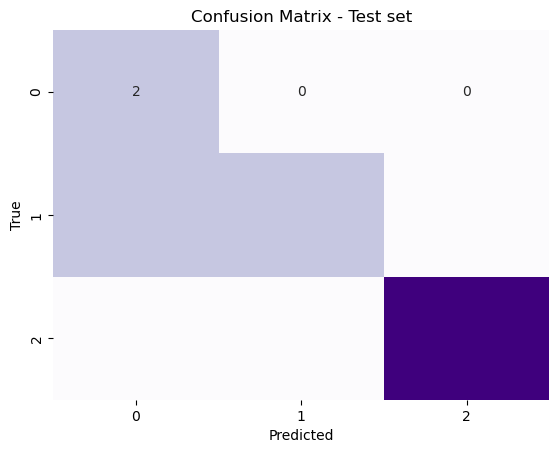

In [157]:
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_test_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_test_pred, average='weighted'))

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, cmap='Purples', fmt='g', cbar=False)
plt.title('Confusion Matrix - Test set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

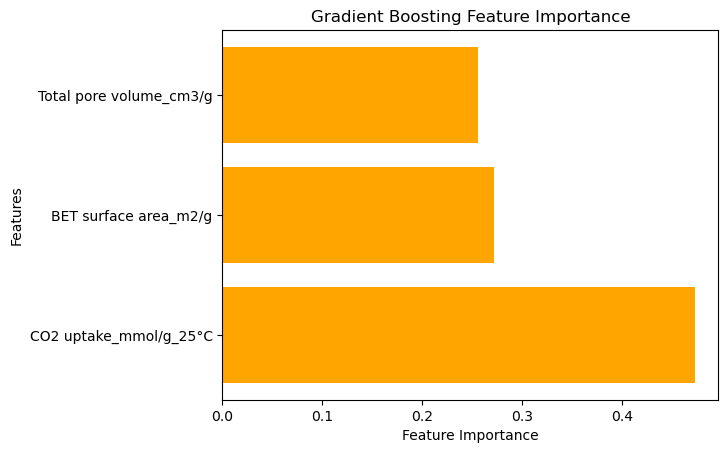

In [158]:
feature_imp = pd.Series(gb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
bar_color = 'orange'
plt.barh(feature_imp.index, feature_imp, color=bar_color)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Feature Importance')
plt.show()

As we can see in the chart above, the hyperparameter adjustments improved inclusively the feature's importance. In this case, CO<sub>2</sub> was the main feature that contributed to the model's performance.

#### Results of Grid search - GB

+---------------------+---------+--------+
| Metrics, 20% test   |   Train |   Test |
+=====================+=========+========+
| Accuracy            |   0.8   | 0.833  |
+---------------------+---------+--------+
| Precision           |   0.805 | 0.916  |
+---------------------+---------+--------+
| Recall              |   0.8   | 0.833  |
+---------------------+---------+--------+
| F1 Score            |   0.79  | 0.8333 |
+---------------------+---------+--------+
Grid Search - GB: learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1


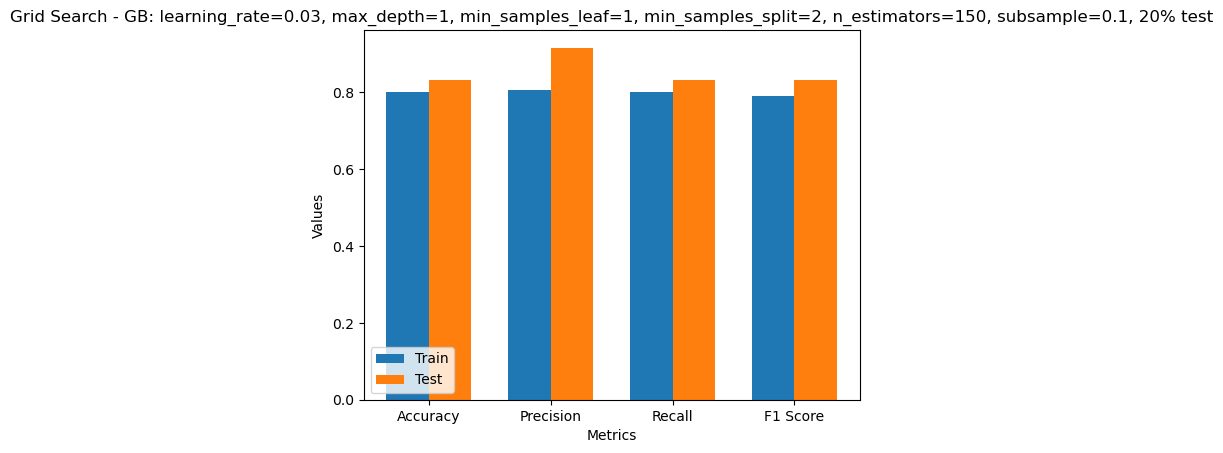

In [161]:
data = [
    ["Accuracy", 0.8, 0.833],
    ["Precision", 0.805, 0.916],
    ["Recall", 0.8, 0.833],
    ["F1 Score", 0.790, 0.8333],
]   
headers = ["Metrics, 20% test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))
print("Grid Search - GB: learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1")

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, label="Test")

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend(loc='lower left')

    plt.show()

plot_data(data, headers, "Grid Search - GB: learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1, 20% test")

## Gradient Boosting - SMOTE 

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45, 3), (12, 3), (45,), (12,))

I am Applying SMOTE to the training set only. If I apply it to the entire dataset, it will result in an overfit of the negative class, which will generate excellent metrics but not in accordance with the real dataset.

In [165]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled.shape, y_train_resampled.shape

((48, 3), (48,))

I will use the code below to call the Gradient Boosting Classifier with the data balanced (SMOTE), and then I will train the model using the training sets and make predictions on the test set.

In [167]:
gb_clf_smote = GradientBoostingClassifier(learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1, random_state=12)

y_train_pred = cross_val_predict(gb_clf_smote, X_train_resampled, y_train_resampled, cv=5)

In [168]:
gb_clf_smote.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.03, max_depth=1, n_estimators=150,
                           random_state=12, subsample=0.1)

Making predictions on the test set.

In [170]:
y_pred_smote = gb_clf_smote.predict(X_test)

Making predictions on the training set.

In [172]:
y_train_pred_smote = gb_clf_smote.predict(X_train_resampled)

####  Training Set Metrics  - SMOTE - GB

In [174]:
print("Training Set Metrics:")
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred_smote))
print("Precision:", precision_score(y_train_resampled, y_train_pred_smote, average='weighted'))
print("Recall:", recall_score(y_train_resampled, y_train_pred_smote, average='weighted'))
print("F1-Score:", f1_score(y_train_resampled, y_train_pred_smote, average='weighted'))

Training Set Metrics:
Accuracy: 0.8958333333333334
Precision: 0.9008940620782727
Recall: 0.8958333333333334
F1-Score: 0.8931239737274219


####  Test Set Metrics  - SMOTE - GB

In [176]:
print("\nTest Set Metrics:")
print( "Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred_smote)) )
print( "precision: {:.2f}".format(metrics.precision_score(y_test, y_pred_smote, average='weighted')) )
print( "recall: {:.2f}".format(metrics.recall_score(y_test, y_pred_smote, average='weighted')) )
print( "F1 Score: {:.2f}".format(metrics.f1_score(y_test, y_pred_smote, average='weighted')) )


Test Set Metrics:
Accuracy: 0.92
precision: 0.93
recall: 0.92
F1 Score: 0.92


####  Accuracy - SMOTE - GB - train and test 

In [178]:
print("Training Accuracy :", gb_clf_smote.score(X_train, y_train))
print("Testing Accuracy :", gb_clf_smote.score(X_test, y_test))

Training Accuracy : 0.8888888888888888
Testing Accuracy : 0.9166666666666666


####  Feature Importance - SMOTE - GB

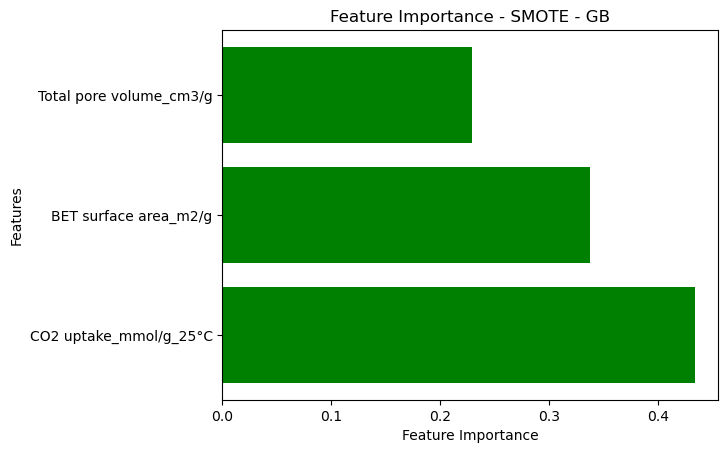

In [180]:
feature_imp = pd.Series(gb_clf_smote.feature_importances_, index=X.columns).sort_values(ascending=False)
bar_color = 'green'
plt.barh(feature_imp.index, feature_imp, color=bar_color)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - SMOTE - GB')
plt.show()

Text(50.72222222222221, 0.5, 'Actual')

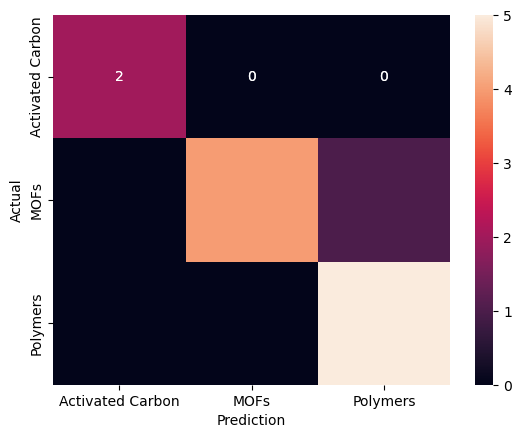

In [181]:
cm = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm, annot=True)
ax = sns.heatmap(cm, annot=True,                  
                 xticklabels=['Activated Carbon', 'MOFs', 'Polymers'],                
                 yticklabels=['Activated Carbon', 'MOFs', 'Polymers'],                  
                 cbar=False)
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")

+--------------------+---------+--------+
| Metrics, 20%test   |   Train |   Test |
+====================+=========+========+
| Accuracy           |   0.895 |   0.92 |
+--------------------+---------+--------+
| Precision          |   0.9   |   0.93 |
+--------------------+---------+--------+
| Recall             |   0.895 |   0.92 |
+--------------------+---------+--------+
| F1 Score           |   0.893 |   0.92 |
+--------------------+---------+--------+
Grid Search - GB: learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1


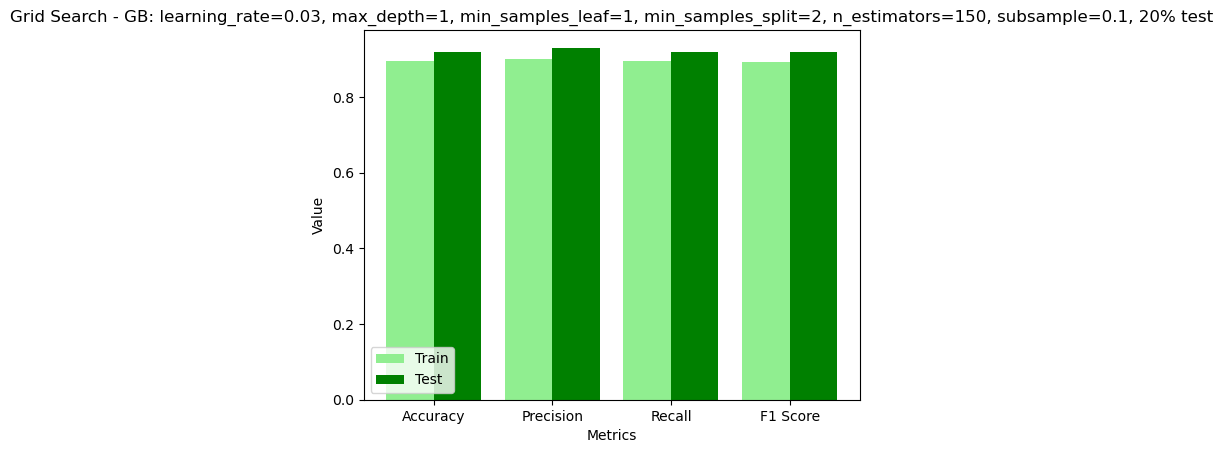

In [182]:
data = [
    ["Accuracy", 0.895, 0.92],
    ["Precision", 0.900, 0.93],
    ["Recall", 0.895, 0.92],
    ["F1 Score", 0.893, 0.92],
]   
headers = ["Metrics, 20%test", "Train", "Test"]

print(tabulate(data, headers=headers, tablefmt="grid"))
print("Grid Search - GB: learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1")

def plot_data(data, headers, title):
    categories = [row[0] for row in data]
    values_train = [row[1] for row in data]
    values_test = [row[2] for row in data]

    bar_width = 0.4
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    train_bars = ax.bar(index, values_train, bar_width, color="lightgreen", label="Train")
    test_bars = ax.bar(index + bar_width, values_test, bar_width, color="green", label="Test")

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend(loc='lower left')

plot_data(data, headers, "Grid Search - GB: learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1, 20% test")

## Conclusion

I found that the Gradient Boosting performed better than k-NN using the SMOTE and under these conditions (learning_rate=0.03, max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150, subsample=0.1, 20% test) including cross-validation and I also used to Grid Search that gave the optimal hyperparameters.

I achieved a training accuracy (0.89) lower than the testing accuracy (0.92), suggesting that the model does not overfit the training data, which is a good sign, and similar results were encountered in the other metrics that can corroborate it. In other words, they present the ability to correctly identify positive instances, which is essential in the present model because the objective is to predict the correct material given a specific CO<sub>2</sub> value. The test set can also generalize well unseen data. However, it will be necessary to increase the sample size, mainly to enhance the confiability of the results. 

## Reference

Chawla, N.V., Bowyer, K.W., Hall, L.O. and Kegelmeyer, W.P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. *Journal of Artificial Intelligence Research*, [online] 16(16), pp.321–357. doi:https://doi.org/10.1613/jair.953.

Chawla, N.V. (2010). Data Mining for Imbalanced Datasets: An Overview. In: Data Mining and Knowledge Discovery Handbook. [online] pp.875–886. doi:https://doi.org/10.1007/978-0-387-09823-4_45.

Devore, J.L. (2012). Probability and Statistics for Engineering and the Sciences. 8th ed. Boston, MA: Brooks/Cole Pub Co.

Dziejarski, B., Serafin, J., Andersson, K. and Krzyżyńska, R. (2023). CO2 capture materials: a review of current trends and future challenges. Materials Today Sustainability, 24, p.100483. doi:https://doi.org/10.1016/j.mtsust.2023.100483.

imbalanced-learn.org. (n.d.). SMOTE — Version 0.11.0. [online] Available at: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#r001eabbe5dd7-1 [Accessed 28 Apr. 2024].

Müller, A. C. and Guido, S. (2017). *Introduction to machine learning with Python: a guide for data scientists*. 1st ed. United States of America. O’reilly Media.

Nicholas, J. (1999). *Introduction to Descriptive Statistics*. Sydney: Mathematics Learning Centre, University Of Sydney.

scikit-learn (2019). sklearn.metrics.f1_score — scikit-learn 0.21.2 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html [Accessed 29 Apr. 2024].

scikit-learn. (n.d.). sklearn.preprocessing.RobustScaler. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler [Accessed 2 Dec. 2023].


